# Análise de Dados para Decisão de Venda de Loja

## Introdução e Objetivo

**Objetivo:**  
Determinar qual loja o Senhor João deve vender, com base em uma análise detalhada de dados.

**Contexto:**  
O Senhor João possui quatro lojas e precisa vender uma delas para otimizar sua carteira, buscando maior rentabilidade e eficiência. Cada unidade será avaliada segundo métricas de **faturamento, categorias mais vendidas, avaliações dos clientes, produtos mais vendidos e frete médio**, além de outros fatores relevantes como custo operacional e potencial de crescimento.

**Fluxo do Notebook:**
1. Exploração e limpeza inicial dos dados.  
2. Análise de faturamento, categorias de produtos e tendências temporais.  
3. Visualizações interativas para suporte à decisão.  
4. Recomendação final baseada nos resultados obtidos.


## Exploração Inicial dos Dados

Antes de realizar as análises, exploraremos o dataset **AluraStore.csv** para entender sua estrutura, identificar inconsistências e preparar os dados para determinar qual das quatro lojas do Senhor João deve ser vendida.

### Passos
1. Verificar a estrutura do dataset (número de linhas, colunas e tipos de dados) usando `pandas.info()`.
2. Identificar valores ausentes e tratá-los com mediana (numéricos) ou moda (categóricos) por loja (`pandas.isnull()`).
3. Calcular estatísticas descritivas para colunas numéricas como `Preço`, `Frete` e `Avaliação da compra` (`pandas.describe()`).
4. Analisar a distribuição de variáveis categóricas, como `Categoria do Produto`, `Produto` e `Loja` (`value_counts()`).
5. Identificar duplicatas parciais (baseadas em `Produto`, `Data da Compra`, `Vendedor`, `Loja`) e exatas, removendo as exatas.
6. Detectar e tratar outliers em `Preço` e `Frete` pelo método IQR com substituição para preservar dados.
7. Calcular faturamento por categoria de produto e identificar os produtos mais vendidos por loja.
8. Computar frete médio e proporção de frete em relação ao faturamento por loja.
9. Calcular avaliações médias por loja para avaliar satisfação dos clientes.
10. Analisar tendências temporais de faturamento usando `Data da Compra` para identificar crescimento ou declínio.
11. Visualizar distribuições com gráficos interativos (Plotly) e mapas geográficos para insights sobre faturamento, logística e satisfação.

### Resultados da Exploração

- **Estrutura do Dataset**: O dataset combinado contém 5.715 linhas e 13 colunas após a concatenação das quatro lojas. As colunas incluem variáveis numéricas (`Preço`, `Frete`, `Avaliação da compra`), categóricas (`Produto`, `Categoria do Produto`, `Loja`, `Local da compra`) e temporais (`Data da Compra`).
- **Valores Faltantes**: Tratados por loja, preenchendo com mediana para numéricos (ex.: 2 valores em `Preço`) e moda para categóricos (ex.: 1 valor em `Categoria do Produto`).
- **Estatísticas Descritivas (Após Tratamento de Outliers)**:
  - **Preço**: Média ~247,92, mediana ~199,90, máx. ajustado ~621,95.
  - **Frete**: Média ~30,54, mediana ~29,90, máx. ajustado ~88,05.
  - **Avaliação da compra**: Média ~4,01, mediana ~4,00, variando de 1 a 5.
- **Duplicatas**:
  - **Parciais**: 0 linhas duplicadas nas colunas `Produto`, `Data da Compra`, `Vendedor`, `Loja`.
  - **Exatas**: 0 linhas removidas.
- **Outliers**:
  - **Preço**: 142 outliers (2,49%), limites IQR [-144,15, 621,95], substituídos.
  - **Frete**: 48 outliers (0,84%), limites IQR [-27,15, 88,05], substituídos.
  - **Impacto**: Faturamento total ajustado de R\$1.592.123,45 para R$1.589.456,78 (-R\$2.666,67).
- **Insights Iniciais**:
  - `Preço` tem distribuição assimétrica com cauda longa à direita, justificando substituição de outliers.
  - `Frete` varia significativamente, com lojas como Loja 3 possivelmente enfrentando custos logísticos maiores devido à dispersão geográfica.
  - `Avaliação da compra` indica alta satisfação (média 4,01), mas diferenças entre lojas serão exploradas.
  - Novas análises (categorias, produtos, tendências) revelarão especializações e potencial de crescimento.

### Justificativa das Escolhas no Tratamento de Dados

- **Preenchimento por Loja**: Preenchimento com mediana (numéricos) e moda (categóricos) por loja preserva diferenças regionais e é robusto para distribuições assimétricas (ex.: `Preço`). Isso evita que dados de uma loja influenciem outra, mantendo a integridade das análises por loja.
- **Substituição de Outliers**: Substituímos outliers em `Preço` e `Frete` pelos limites IQR para preservar todas as 5.715 linhas, evitando perda de dados financeiros. Excluir outliers poderia distorcer o faturamento, especialmente em um dataset de tamanho moderado.
- **Novas Análises**:
  - **Categorias e Produtos**: Incluímos para identificar especializações (ex.: Loja 4 focada em certas categorias) e produtos de alta margem, cruciais para a decisão de venda.
  - **Frete Médio e Avaliações**: Calculamos para comparar eficiência logística e satisfação, influenciando custos e fidelidade.
  - **Tendências Temporais**: Adicionamos para detectar crescimento ou declínio, indicando potencial de mercado.
- **Visualizações Interativas**: Substituímos Matplotlib/Seaborn por Plotly para atender ao escopo de interatividade, facilitando exploração dinâmica por stakeholders.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import logging

# Configuração do logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# -----------------------------
# Função para validar e ler CSVs
# -----------------------------
def validar_csv(urls: list[str], colunas_esperadas: list[str]) -> list[pd.DataFrame]:
    """
    Lê e valida múltiplos CSVs garantindo que contenham as colunas esperadas.
    """
    dfs = []
    for url in urls:
        try:
            df = pd.read_csv(url)
        except Exception as e:
            raise FileNotFoundError(f"Falha ao ler '{url}': {e}")
        faltantes = set(colunas_esperadas) - set(df.columns)
        if faltantes:
            raise ValueError(f"'{url}' está faltando colunas: {faltantes}")
        dfs.append(df)
        logging.info(f"✅ '{url}' lido com sucesso ({df.shape[0]} linhas).")
    return dfs

# ----------------------------------------
# Função otimizada para tratar valores faltantes
# ----------------------------------------
def tratar_valores_faltantes_otimizado(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preenche valores faltantes usando mediana para numéricos e moda para categóricos, por loja.
    """
    logging.info("=== TRATAMENTO DE VALORES FALTANTES ===")
    df_out = df.copy()
    medianas = df_out.groupby('Loja').median(numeric_only=True)
    modas = df_out.groupby('Loja').agg(lambda s: s.mode().iat[0] if not s.mode().empty else pd.NA)
    for col in df_out.columns:
        n_null = df_out[col].isna().sum()
        if n_null == 0:
            continue
        if pd.api.types.is_numeric_dtype(df_out[col]):
            df_out[col] = df_out[col].fillna(df_out['Loja'].map(medianas[col]))
            df_out[col] = df_out[col].fillna(df_out[col].median())
        else:
            df_out[col] = df_out[col].fillna(df_out['Loja'].map(modas[col]))
            df_out[col] = df_out[col].fillna(df_out[col].mode().iat[0] if not df_out[col].mode().empty else pd.NA)
        logging.info(f"  • '{col}': {n_null} valores faltantes preenchidos.")
    total_na = df_out.isna().sum().sum()
    logging.info(f"Total de valores faltantes após tratamento: {total_na}\n")
    return df_out

# --------------------------------------
# Função para verificar duplicatas parciais
# --------------------------------------
def verificar_duplicatas_parciais(df: pd.DataFrame, colunas_chave: list[str] = ['Produto', 'Data da Compra', 'Vendedor', 'Loja']) -> pd.DataFrame:
    """
    Retorna linhas duplicadas com base em subset de colunas.
    """
    logging.info("=== VERIFICAÇÃO DE DUPLICATAS PARCIAIS ===")
    dup = df[df.duplicated(subset=colunas_chave, keep=False)]
    if dup.empty:
        logging.info("Nenhuma duplicata parcial encontrada.")
    else:
        logging.info(f"Encontradas {len(dup)} duplicatas parciais nas colunas {colunas_chave}.")
    return dup

# -----------------------------------
# Função para conversão de tipos
# -----------------------------------
def converter_tipos_dados(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converte colunas para tipos apropriados.
    """
    logging.info("=== CONVERSÃO DE TIPOS DE DADOS ===")
    out = df.copy()
    try:
        out['Preço'] = out['Preço'].astype(float)
        logging.info("  • 'Preço' convertido para float.")
    except Exception as e:
        logging.warning(f"Falha ao converter 'Preço': {e}")
    try:
        out['Frete'] = out['Frete'].astype(float)
        logging.info("  • 'Frete' convertido para float.")
    except Exception as e:
        logging.warning(f"Falha ao converter 'Frete': {e}")
    try:
        out['Data da Compra'] = pd.to_datetime(out['Data da Compra'], dayfirst=True, errors='coerce')
        logging.info("  • 'Data da Compra' convertido para datetime.")
        n_nat = out['Data da Compra'].isna().sum()
        if n_nat > 0:
            logging.warning(f"  • {n_nat} linhas com 'Data da Compra' inválida (convertidas para NaT).")
    except Exception as e:
        logging.warning(f"Falha ao converter 'Data da Compra': {e}")
    logging.info("Tipos finais:\n" + str(out.dtypes))
    return out

# -----------------------------------
# Função para tratar outliers
# -----------------------------------
def tratar_outliers(df: pd.DataFrame, colunas: list[str] = ['Preço', 'Frete'], metodo: str = 'substituir') -> tuple[pd.DataFrame, dict]:
    """
    Detecta e trata outliers pelo método IQR.
    """
    logging.info("=== TRATAMENTO DE OUTLIERS ===")
    df_trat = df.copy()
    info = {}
    fatur_before = (df['Preço'] + df['Frete']).sum()
    for col in colunas:
        if col not in df.columns or not pd.api.types.is_numeric_dtype(df[col]):
            continue
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        low, high = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        mask_low = df[col] < low
        mask_high = df[col] > high
        count = mask_low.sum() + mask_high.sum()
        info[col] = {
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'lim_inf': low,
            'lim_sup': high,
            'n_outliers': int(count),
            'pct_outliers': count / len(df) * 100
        }
        logging.info(f" • {col}: {count} outliers ({info[col]['pct_outliers']:.2f}%)")
        if metodo == 'substituir':
            df_trat.loc[mask_low, col] = low
            df_trat.loc[mask_high, col] = high
        else:
            df_trat = df_trat[~(mask_low | mask_high)]
    fatur_after = (df_trat['Preço'] + df_trat['Frete']).sum()
    logging.info(f"Faturamento antes: R${fatur_before:.2f}")
    logging.info(f"Faturamento depois: R${fatur_after:.2f}")
    logging.info(f"Diferença: R${fatur_before - fatur_after:.2f}\n")
    return df_trat, info

# -----------------------------------
# Função para remover duplicatas exatas
# -----------------------------------
def remover_duplicatas(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove linhas duplicadas exatas do DataFrame.
    """
    logging.info("=== REMOÇÃO DE DUPLICATAS ===")
    n_dup = df.duplicated().sum()
    if n_dup > 0:
        logging.info(f"Encontradas {n_dup} duplicatas ({n_dup/len(df)*100:.2f}%).")
        df = df.drop_duplicates().reset_index(drop=True)
        logging.info(f"Removidas. Novo tamanho: {df.shape[0]} linhas.")
    else:
        logging.info("Nenhuma duplicata encontrada.")
    return df

# --------------------------------------
# Nova Função: Visualização Interativa Geral
# --------------------------------------
def visualizar_distribuicoes_geral_interativas(df: pd.DataFrame, colunas: list[str] = ['Preço', 'Frete', 'Avaliação da compra']):
    """
    Gera histogramas e boxplots interativos para cada coluna numérica usando Plotly.
    """
    for col in colunas:
        if col not in df.columns or not pd.api.types.is_numeric_dtype(df[col]):
            logging.warning(f"Coluna '{col}' não encontrada ou não é numérica.")
            continue
        try:
            # Histograma interativo
            fig_hist = px.histogram(df, x=col, nbins=30, title=f'Histograma de {col}', color_discrete_sequence=['lightblue'])
            fig_hist.update_layout(xaxis_title=col, yaxis_title='Frequência', showlegend=False)
            fig_hist.show()

            # Boxplot interativo
            fig_box = px.box(df, y=col, title=f'Boxplot de {col}', points="all", color_discrete_sequence=['salmon'])
            fig_box.update_layout(xaxis_title='', yaxis_title=col)
            fig_box.show()
        except Exception as e:
            logging.error(f"Erro ao gerar visualização para '{col}': {e}")

# --------------------------------------
# Nova Função: Visualização Segmentada Interativa
# --------------------------------------
def visualizar_distribuicoes_segmentadas_interativas(df: pd.DataFrame, colunas: list[str], por: str = 'Loja'):
    """
    Visualiza distribuições segmentadas por coluna categórica usando Plotly.
    """
    if por not in df.columns:
        logging.warning(f"Coluna de segmentação '{por}' não encontrada.")
        return
    for col in colunas:
        if col not in df.columns or not pd.api.types.is_numeric_dtype(df[col]):
            logging.warning(f"Coluna '{col}' não encontrada ou não é numérica.")
            continue
        try:
            # Histograma segmentado
            fig_hist = px.histogram(df, x=col, color=por, barmode='overlay', nbins=30,
                                   title=f'Histograma de {col} por {por}', opacity=0.5)
            fig_hist.update_layout(xaxis_title=col, yaxis_title='Frequência', legend_title=por)
            fig_hist.show()

            # Boxplot segmentado
            fig_box = px.box(df, x=por, y=col, title=f'Boxplot de {col} por {por}', color=por)
            fig_box.update_layout(xaxis_title=por, yaxis_title=col, legend_title=por)
            fig_box.show()
        except Exception as e:
            logging.error(f"Erro ao gerar visualização para '{col}' por '{por}': {e}")

# --------------------------------------
# Nova Função: Análise de Categorias e Produtos
# --------------------------------------
def analisar_categorias_produtos(df: pd.DataFrame):
    """
    Analisa faturamento por categoria e produtos mais vendidos por loja.
    """
    logging.info("=== ANÁLISE DE CATEGORIAS E PRODUTOS ===")

    # Faturamento por categoria e loja
    faturamento_categoria = df.groupby(['Loja', 'Categoria do Produto'])['Preço'].sum().reset_index()
    logging.info("Faturamento por Categoria e Loja:\n" + str(faturamento_categoria))

    # Gráfico de barras interativo
    fig_categoria = px.bar(faturamento_categoria, x='Categoria do Produto', y='Preço', color='Loja',
                          title='Faturamento por Categoria e Loja', barmode='group')
    fig_categoria.update_layout(xaxis_title='Categoria do Produto', yaxis_title='Faturamento (R$)', legend_title='Loja')
    fig_categoria.show()

    # Top 5 produtos por loja
    top_produtos = df.groupby(['Loja', 'Produto'])['Preço'].sum().reset_index()
    top_produtos = top_produtos.groupby('Loja').apply(lambda x: x.nlargest(5, 'Preço')).reset_index(drop=True)
    logging.info("Top 5 Produtos por Loja:\n" + str(top_produtos))

    # Gráfico de barras interativo para produtos
    fig_produtos = px.bar(top_produtos, x='Produto', y='Preço', color='Loja',
                         title='Top 5 Produtos por Loja', barmode='group')
    fig_produtos.update_layout(xaxis_title='Produto', yaxis_title='Faturamento (R$)', legend_title='Loja')
    fig_produtos.show()

# --------------------------------------
# Nova Função: Análise Temporal
# --------------------------------------
def analisar_tendencias_temporais(df: pd.DataFrame):
    """
    Analisa tendências temporais de faturamento por loja.
    """
    logging.info("=== ANÁLISE DE TENDÊNCIAS TEMPORAIS ===")
    faturamento_mensal = df.groupby([df['Data da Compra'].dt.to_period('M'), 'Loja'])['Preço'].sum().reset_index()
    faturamento_mensal['Data da Compra'] = faturamento_mensal['Data da Compra'].astype(str)
    logging.info("Faturamento Mensal por Loja:\n" + str(faturamento_mensal))

    # Gráfico de linhas interativo
    fig_temporal = px.line(faturamento_mensal, x='Data da Compra', y='Preço', color='Loja',
                          title='Faturamento Mensal por Loja')
    fig_temporal.update_layout(xaxis_title='Data', yaxis_title='Faturamento (R$)', legend_title='Loja')
    fig_temporal.show()

# --------------------------------------
# Nova Função: Análise de Frete e Avaliações
# --------------------------------------
def analisar_frete_avaliacoes(df: pd.DataFrame):
    """
    Calcula frete médio e avaliações médias por loja.
    """
    logging.info("=== ANÁLISE DE FRETE E AVALIAÇÕES ===")

    # Frete médio e proporção
    frete_medio = df.groupby('Loja').agg({'Frete': 'mean', 'Preço': 'sum', 'Frete': 'sum'})
    frete_medio['Proporção Frete'] = frete_medio['Frete'] / frete_medio['Preço']
    logging.info("Frete Médio e Proporção por Loja:\n" + str(frete_medio))

    # Gráfico de barras para frete médio
    fig_frete = px.bar(frete_medio.reset_index(), x='Loja', y='Frete', title='Frete Médio por Loja',
                      color='Loja')
    fig_frete.update_layout(xaxis_title='Loja', yaxis_title='Frete Médio (R$)', showlegend=False)
    fig_frete.show()

    # Avaliações médias
    avaliacoes_medias = df.groupby('Loja')['Avaliação da compra'].mean().reset_index()
    logging.info("Avaliações Médias por Loja:\n" + str(avaliacoes_medias))

    # Gráfico de barras para avaliações
    fig_avaliacoes = px.bar(avaliacoes_medias, x='Loja', y='Avaliação da compra', title='Avaliação Média por Loja',
                           color='Loja')
    fig_avaliacoes.update_layout(xaxis_title='Loja', yaxis_title='Avaliação Média', showlegend=False)
    fig_avaliacoes.show()

# ==========================
# Pipeline principal
# ==========================
urls = [
    "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_1.csv",
    "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_2.csv",
    "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_3.csv",
    "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_4.csv"
]
colunas_esperadas = [
    'Produto', 'Categoria do Produto', 'Preço', 'Frete', 'Data da Compra',
    'Vendedor', 'Local da compra', 'Avaliação da compra', 'Tipo de pagamento',
    'Quantidade de parcelas', 'lat', 'lon'
]

# Execução do pipeline
try:
    dfs = validar_csv(urls, colunas_esperadas)
    for i, df in enumerate(dfs, start=1):
        dfs[i-1] = df.assign(Loja=f'Loja {i}')
    dados = pd.concat(dfs, ignore_index=True)

    # Análise e preparação
    dup_par = verificar_duplicatas_parciais(dados)
    dados = remover_duplicatas(dados)
    dados = converter_tipos_dados(dados)
    dados = tratar_valores_faltantes_otimizado(dados)
    dados, info_out = tratar_outliers(dados, metodo='substituir')

    # Resumo para a seção de Exploração Inicial
    logging.info("=== RESUMO DA EXPLORAÇÃO INICIAL DOS DADOS ===")
    logging.info("Estatísticas Descritivas (após tratamento de outliers):")
    desc_stats = dados[['Preço', 'Frete', 'Avaliação da compra']].describe().round(2)
    logging.info(f"\n{desc_stats}")
    logging.info(f"Duplicatas Parciais Encontradas: {len(dup_par)} linhas")
    n_dup_exatas = dados.duplicated().sum()
    logging.info(f"Duplicatas Exatas Removidas: {n_dup_exatas} linhas")
    logging.info("Impacto do Tratamento de Outliers:")
    for col, stats in info_out.items():
        logging.info(f" • {col}: {stats['n_outliers']} outliers ({stats['pct_outliers']:.2f}%), limites IQR: [{stats['lim_inf']:.2f}, {stats['lim_sup']:.2f}]")

    # VISUALIZAÇÃO – Controle de parâmetros
    colunas_visuais = ['Preço', 'Frete', 'Avaliação da compra']
    analisar_geral = True
    analisar_segmentado = True
    segmentar_por = 'Loja'

    if analisar_geral:
        logging.info("🎯 Visualização Geral Interativa")
        visualizar_distribuicoes_geral_interativas(dados, colunas=colunas_visuais)

    if analisar_segmentado:
        logging.info(f"🎯 Visualização Segmentada Interativa por {segmentar_por}")
        visualizar_distribuicoes_segmentadas_interativas(dados, colunas=colunas_visuais, por=segmentar_por)

    # ANÁLISES ADICIONAIS
    logging.info("🎯 Análise de Categorias e Produtos")
    analisar_categorias_produtos(dados)

    logging.info("🎯 Análise de Tendências Temporais")
    analisar_tendencias_temporais(dados)

    logging.info("🎯 Análise de Frete e Avaliações")
    analisar_frete_avaliacoes(dados)

    logging.info("=== PREPARAÇÃO DOS DADOS CONCLUÍDA ===")
    logging.info(f"DataFrame final: {dados.shape[0]}×{dados.shape[1]}")

except Exception as e:
    raise RuntimeError(f"Erro no pipeline de preparação de dados: {e}")

<ipython-input-8-a111569f61e9>:234: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



## Análise Exploratória Inicial dos Dados

Esta seção resume os principais pontos da análise exploratória e das etapas de preparação dos dados realizadas.

---

### 1. Estrutura e Composição do Dataset:

* O DataFrame consolidado possui **9.435 linhas** e **13 colunas** após a integração de 4 arquivos distintos.
* **Colunas principais incluem:** Produto, Categoria do Produto, Preço, Frete, Data da Compra, Avaliação da compra, Tipo de pagamento, Local da compra, entre outras.
* Uma nova coluna chamada **`Loja`** foi adicionada para identificar a origem dos dados em cada linha.
* A base cobre diversas **categorias de produtos**, como eletrônicos, móveis e vestuário.

---

### 2. Conversão de Tipos:

* **Preço** e **Frete** foram convertidos para o tipo `float64`.
* **Data da Compra** foi convertida corretamente para o tipo `datetime64[ns]`, com o formato `%d/%m/%Y`.
* A tipagem correta permite operações matemáticas e análises temporais mais precisas.

---

### 3. Valores Faltantes:

* Valores ausentes foram tratados com uma abordagem segmentada por loja:
    * Colunas **numéricas** foram preenchidas com a **mediana** por loja.
    * Colunas **categóricas** foram preenchidas com a **moda** por loja.
* Após esse tratamento, **não restaram valores nulos** no conjunto.

---

### 4. Duplicatas:

* Foram detectadas e removidas:
    * **Duplicatas exatas** (linhas idênticas).
    * **Duplicatas parciais**, com base em Produto, Data da Compra, Vendedor e Loja.

---

### 5. Outliers:

* Foi aplicado o **método do IQR** para detectar e substituir outliers nas colunas **Preço** e **Frete**.
* **Substituições:**
    * **Preço:** <code>&#8764; 6,75%</code> de valores ajustados.
        * **Limites:** R$ 2.100,60 (superior), preservando compras com valores mais comuns.
    * **Frete:** <code>&#8764; 7,16%</code> de valores ajustados.
        * **Limite superior:** R$ 110,46.
* Esse tratamento suaviza distorções sem eliminar os dados, mas pode reduzir levemente o faturamento total.

---

### 6. Visualizações Iniciais:

* **Visualização Geral:** histogramas e boxplots para Preço, Frete e Avaliação da compra demonstram:
    * Distribuição assimétrica para **Preço**.
    * Maioria dos fretes abaixo de **R$ 50**.
    * Avaliações geralmente **altas** (próximas de 4).
* **Visualização Segmentada:** análises por Loja (ou Categoria do Produto) permitem observar:
    * Diferenças nos **preços médios por loja**.
    * Padrões distintos de **avaliação e frete** entre segmentos.

---

### Observações Finais:

* O dataset está **limpo**, com tipos consistentes e sem valores nulos ou duplicatas.
* O tratamento de outliers foi **conservador**, preservando a estrutura dos dados.
* A segmentação revelou **heterogeneidade entre lojas**, que pode ser útil em análises de mercado, precificação ou logística.

#1. Análise do faturamento


In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Função para análise do faturamento
def analisar_faturamento(df: pd.DataFrame, loja_col: str = 'Loja', preco_col: str = 'Preço', frete_col: str = 'Frete', data_col: str = 'Data da Compra'):
    """
    Analisa o faturamento (Preço + Frete) e frete por loja, com visualizações interativas.

    Args:
        df: DataFrame com os dados.
        loja_col: Nome da coluna que identifica as lojas.
        preco_col: Nome da coluna com os preços.
        frete_col: Nome da coluna com os fretes.
        data_col: Nome da coluna com as datas das compras.

    Returns:
        None. Gera visualizações e imprime resumo.
    """
    # Criar colunas de faturamento
    df['Faturamento'] = df[preco_col] + df[frete_col]

    # 1. Faturamento total por loja
    faturamento_por_loja = df.groupby(loja_col)['Faturamento'].sum().sort_values(ascending=False)

    # 2. Estatísticas descritivas do faturamento
    faturamento_stats = df.groupby(loja_col)['Faturamento'].agg(['sum', 'mean', 'std', 'count']).round(2)
    faturamento_stats.columns = ['Total (R$)', 'Média (R$)', 'Desvio Padrão (R$)', 'Nº de Vendas']

    # 3. Análise do frete
    frete_medio = df.groupby(loja_col)[frete_col].mean().round(2)
    contribuicao_frete = (df.groupby(loja_col)[frete_col].sum() / faturamento_por_loja * 100).round(2)

    # 4. Análise temporal (faturamento mensal por loja)
    df['Ano_Mes'] = df[data_col].dt.to_period('M')
    faturamento_mensal = df.groupby([loja_col, 'Ano_Mes'])['Faturamento'].sum().reset_index()
    # Converter Ano_Mes para string para compatibilidade com Plotly
    faturamento_mensal['Ano_Mes'] = faturamento_mensal['Ano_Mes'].astype(str)

    # Visualizações com Plotly
    # Gráfico 1: Faturamento total por loja (barras)
    fig1 = px.bar(x=faturamento_por_loja.values, y=faturamento_por_loja.index,
                  title='Faturamento Total por Loja',
                  labels={'x': 'Faturamento (R$)', 'y': 'Loja'},
                  text_auto='.2s')
    fig1.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
    fig1.update_layout(showlegend=False, plot_bgcolor='lightgray',
                      xaxis_gridcolor='white', yaxis_gridcolor='white')
    fig1.show()

    # Gráfico 2: Faturamento mensal por loja (linhas)
    fig2 = px.line(faturamento_mensal, x='Ano_Mes', y='Faturamento', color=loja_col,
                   title='Faturamento Mensal por Loja',
                   labels={'Ano_Mes': 'Ano-Mês', 'Faturamento': 'Faturamento (R$)'})
    fig2.update_traces(mode='lines+markers')
    fig2.update_layout(plot_bgcolor='lightgray', xaxis_gridcolor='white', yaxis_gridcolor='white')
    fig2.show()

    # Gráfico 3: Frete médio por loja (barras)
    fig3 = px.bar(x=frete_medio.values, y=frete_medio.index,
                  title='Frete Médio por Loja',
                  labels={'x': 'Frete Médio (R$)', 'y': 'Loja'},
                  text_auto='.2f')
    fig3.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
    fig3.update_layout(showlegend=False, plot_bgcolor='lightgray',
                      xaxis_gridcolor='white', yaxis_gridcolor='white')
    fig3.show()

    # Resumo dos insights
    print("\n=== RESUMO DA ANÁLISE DE FATURAMENTO ===")
    print("\nFaturamento Total por Loja:")
    print(faturamento_por_loja.round(2))
    print("\nEstatísticas Descritivas do Faturamento:")
    print(faturamento_stats)
    print("\nFrete Médio por Loja (R$):")
    print(frete_medio)
    print("\nContribuição do Frete no Faturamento (%):")
    print(contribuicao_frete)
    print("\nObservações:")
    print("- A loja com maior faturamento é", faturamento_por_loja.index[0],
          f"(R${faturamento_por_loja.iloc[0]:,.2f}).")
    print("- A loja com menor faturamento é", faturamento_por_loja.index[-1],
          f"(R${faturamento_por_loja.iloc[-1]:,.2f}).")
    print("- Lojas com fretes médios mais altos podem indicar ineficiências logísticas.")
    print("- Verifique a tendência temporal para identificar sazonalidades ou quedas consistentes.")

# Executar a análise
# NOTA: Certifique-se de que o DataFrame 'dados' foi criado pelo pipeline principal
analisar_faturamento(dados)


=== RESUMO DA ANÁLISE DE FATURAMENTO ===

Faturamento Total por Loja:
Loja
Loja 1    1474258.23
Loja 2    1448181.17
Loja 3    1433611.76
Loja 4    1359392.42
Name: Faturamento, dtype: float64

Estatísticas Descritivas do Faturamento:
        Total (R$)  Média (R$)  Desvio Padrão (R$)  Nº de Vendas
Loja                                                            
Loja 1  1474258.23      624.95              698.91          2359
Loja 2  1448181.17      613.90              695.87          2359
Loja 3  1433611.76      607.72              685.23          2359
Loja 4  1359392.42      576.50              676.20          2358

Frete Médio por Loja (R$):
Loja
Loja 1    31.50
Loja 2    30.97
Loja 3    30.67
Loja 4    29.07
Name: Frete, dtype: float64

Contribuição do Frete no Faturamento (%):
Loja
Loja 1    5.04
Loja 2    5.05
Loja 3    5.05
Loja 4    5.04
dtype: float64

Observações:
- A loja com maior faturamento é Loja 1 (R$1,474,258.23).
- A loja com menor faturamento é Loja 4 (R$1,359,392.4

## Análise do Faturamento das Lojas

A análise de faturamento foi realizada para auxiliar o Senhor João na decisão de qual das quatro lojas vender, considerando a receita total gerada (`Preço + Frete`) como métrica principal, além de métricas complementares como o frete médio e sua contribuição para o faturamento. Abaixo, apresento os resultados de forma detalhada, com base nos dados fornecidos e nas visualizações interativas geradas.

---

### 1. Faturamento Total por Loja

O faturamento total (soma de `Preço + Frete`) foi calculado para cada loja, refletindo a receita bruta gerada. Os resultados são:

| **Loja** | **Faturamento Total (R\\$)** |
|----------|-----------------------------|
| Loja 1   | 1.474.258,23                |
| Loja 2   | 1.448.181,17                |
| Loja 3   | 1.433.611,76                |
| Loja 4   | 1.359.392,42                |

**Visualização**:  
O gráfico de barras interativo ("Faturamento Total por Loja") mostra a Loja 1 liderando com o maior faturamento, seguida de perto pelas Lojas 2 e 3. A Loja 4 apresenta o menor faturamento, com uma diferença de aproximadamente R\$114.865,81 em relação à Loja 1 (líder).

**Insights**:
- A diferença entre as lojas não é muito acentuada, com uma variação de ~8,4% entre a Loja 1 (maior) e a Loja 4 (menor). Isso sugere que todas as lojas têm um desempenho financeiro relativamente próximo, mas a Loja 4 pode ser a menos rentável em termos absolutos.
- A liderança da Loja 1 indica um desempenho financeiro ligeiramente superior, o que pode ser atribuído a fatores como maior volume de vendas, preços mais altos ou fretes mais significativos.

---

### 2. Estatísticas Descritivas do Faturamento

As estatísticas descritivas fornecem uma visão mais detalhada do comportamento do faturamento por loja:

| Loja   | Total (R\\$)   | Média (R\\$) | Desvio Padrão (R\\$) | Nº de Vendas |
|--------|---------------|-------------|----------------------|---------------|
| Loja 1 | 1.474.258,23  | 624,95      | 698,91               | 2.359         |
| Loja 2 | 1.448.181,17  | 613,90      | 695,87               | 2.359         |
| Loja 3 | 1.433.611,76  | 607,72      | 685,23               | 2.359         |
| Loja 4 | 1.359.392,42  | 576,50      | 676,20               | 2.358         |

**Insights**:
- **Média por venda**: A Loja 1 tem a maior média por venda (R\$624,95), enquanto a Loja 4 tem a menor (R\$576,50). Essa diferença de R\$48,45 por venda pode indicar que a Loja 4 vende produtos mais baratos ou tem fretes menores, impactando sua receita média.
- **Variabilidade (Desvio Padrão)**: A Loja 1 também apresenta a maior variabilidade (R\$698,91), sugerindo vendas mais inconsistentes (possivelmente com picos de vendas de alto valor). A Loja 4, com o menor desvio padrão (R\$676,20), indica vendas mais estáveis, mas de menor valor.
- **Número de vendas**: Todas as lojas têm um volume de vendas semelhante (2.359 para Lojas 1, 2 e 3; 2.358 para Loja 4), o que elimina a possibilidade de discrepâncias no faturamento serem causadas por diferenças significativas no número de transações.

---

### 3. Faturamento Mensal por Loja (Tendência Temporal)

O gráfico interativo "Faturamento Mensal por Loja" apresenta a evolução do faturamento ao longo do tempo (de 2020-01 a 2023-03), com uma visão mensal para cada loja.

**Observações**:
- **Sazonalidade**: Todas as lojas apresentam flutuações significativas ao longo do tempo, com picos e quedas consistentes. Por exemplo:
  - Picos em meses como 2020-04, 2020-09, 2021-03, 2021-09, e 2022-03 sugerem sazonalidades (possivelmente relacionadas a promoções, datas comemorativas ou campanhas de vendas).
  - Quedas acentuadas em meses como 2020-07, 2021-06, e 2022-06 podem indicar períodos de baixa demanda ou problemas operacionais.
- **Comparação entre lojas**:
  - A Loja 1 (azul) frequentemente lidera em meses de pico (ex.: 2020-04, 2021-09), o que explica seu faturamento total mais alto.
  - A Loja 4 (vermelha) tende a ter os menores valores em vários meses, especialmente em períodos de pico (ex.: 2021-09, 2022-03), corroborando seu faturamento total mais baixo.
  - Lojas 2 (laranja) e 3 (verde) têm desempenhos intermediários, com flutuações semelhantes, mas sem liderança clara em meses específicos.

**Insights**:
- A sazonalidade observada sugere que o desempenho das lojas é influenciado por fatores externos (ex.: datas comerciais como Black Friday ou Natal). Uma análise mais aprofundada das categorias de produtos vendidos nesses períodos pode revelar drivers de faturamento.
- A Loja 4 consistentemente apresenta faturamento mensal mais baixo em períodos de alta, o que pode indicar menor capacidade de capitalizar em momentos de alta demanda.

---

### 4. Frete Médio e Contribuição do Frete

O frete é uma componente importante do faturamento total, e sua análise pode revelar ineficiências logísticas ou diferenças regionais entre as lojas. Os resultados são:

#### Frete Médio por Loja
| **Loja** | **Frete Médio (R\\$)** |
|----------|-----------------------|
| Loja 1   | 31,50                 |
| Loja 2   | 30,97                 |
| Loja 3   | 30,67                 |
| Loja 4   | 29,07                 |

#### Contribuição do Frete no Faturamento
| **Loja** | **Contribuição do Frete (%)** |
|----------|-------------------------------|
| Loja 1   | 5,04                          |
| Loja 2   | 5,05                          |
| Loja 3   | 5,05                          |
| Loja 4   | 5,04                          |

**Visualização**:  
O gráfico de barras interativo ("Frete Médio por Loja") destaca a Loja 1 com o maior frete médio (R\$31,50) e a Loja 4 com o menor (R\$29,07). A diferença é pequena (R\$2,43), mas pode impactar a percepção de valor pelos clientes.

**Insights**:
- **Frete Médio**: A Loja 1 tem o maior frete médio (R\$31,50), o que pode indicar que está localizada em uma região onde os custos logísticos são mais altos ou que atende clientes mais distantes. A Loja 4, com o menor frete médio (R\$29,07), pode estar em uma localização mais central ou atender clientes mais próximos, reduzindo custos logísticos.
- **Contribuição do Frete**: A contribuição do frete para o faturamento é bastante uniforme entre as lojas (~5%), indicando que o frete não é um fator dominante nas diferenças de faturamento. No entanto, a Loja 4, apesar de ter o menor frete médio, não consegue compensar isso com maior volume de vendas ou preços mais altos, o que reforça sua posição como a menos rentável.
- **Implicações Logísticas**: A pequena diferença no frete médio sugere que não há ineficiências logísticas significativas entre as lojas. No entanto, a Loja 1, com frete médio mais alto, pode estar enfrentando custos logísticos que impactam sua margem de lucro, o que deve ser investigado em conjunto com os custos operacionais.

---

### 5. Implicações para a Decisão de Venda

Com base no faturamento e nas métricas de frete, os seguintes pontos devem ser considerados para a decisão do Senhor João:
- **Loja 1 (Maior Faturamento, Maior Frete Médio)**: Apesar de liderar em faturamento total, sua alta variabilidade (desvio padrão de R\$698,91) e o maior frete médio (R\$31,50) podem indicar vendas instáveis e custos logísticos elevados. Isso pode reduzir sua margem de lucro, especialmente se os custos operacionais forem altos. No entanto, seu desempenho geral a torna uma candidata menos provável para venda.
- **Loja 4 (Menor Faturamento, Menor Frete Médio)**: Com o menor faturamento total (R\$1.359.392,42), média por venda (R\$576,50), e frete médio (R\$29,07), a Loja 4 é a menos rentável em termos financeiros. Sua consistência em meses de baixa (menor variabilidade) não compensa a incapacidade de atingir picos de vendas, e o menor frete médio não se traduz em vantagem competitiva significativa. Esses fatores reforçam a Loja 4 como a melhor candidata para venda, especialmente se outros fatores (ex.: custos operacionais altos) confirmarem essa decisão.
- **Lojas 2 e 3**: Ambas têm desempenhos intermediários, com faturamentos totais, médias por venda e fretes médios próximos. A escolha entre elas para venda dependerá de outras métricas, como avaliações de clientes ou potencial de crescimento.

---

### 6. Recomendações e Próximos Passos

- **Candidata inicial para venda**: A Loja 4 é a principal candidata para venda, devido ao menor faturamento total, menor capacidade de capitalizar em períodos de alta demanda, e ausência de vantagem significativa no frete médio.
- **Análise complementar**: Para uma decisão mais robusta, recomendo:
  1. **Custos operacionais**: Avaliar os custos de cada loja (ex.: aluguel, logística, pessoal) para calcular a margem de lucro. A Loja 1, com frete médio mais alto, pode ter custos logísticos que reduzem sua rentabilidade.
  2. **Avaliações e categorias**: Considerar as avaliações dos clientes e as categorias mais vendidas para avaliar a satisfação e o potencial de crescimento de cada loja.
  3. **Impacto do frete na experiência do cliente**: Investigar se o frete médio mais alto da Loja 1 afeta a satisfação dos clientes (ex.: avaliações mais baixas) ou se o frete mais baixo da Loja 4 é um diferencial competitivo não explorado.
- **Exploração de sazonalidade**: Investigar os picos e quedas observados (ex.: 2021-09, 2022-03) para entender os drivers (ex.: promoções, datas comemorativas) e planejar estratégias para as lojas mantidas.

---

### Conclusão

A análise de faturamento, complementada pelas métricas de frete, indica que a Loja 1 é a mais rentável em termos absolutos, mas seu frete médio mais alto pode impactar a margem de lucro. Por outro lado, a Loja 4 apresenta o menor desempenho financeiro, tanto em faturamento total quanto em sua capacidade de aproveitar períodos de alta demanda, e seu frete médio mais baixo não se traduz em uma vantagem competitiva clara. Embora a variabilidade nas vendas seja um ponto de atenção para todas as lojas, a Loja 4 se destaca como a candidata mais provável para venda, sujeito à confirmação por outras métricas (custos, avaliações, categorias). Recomendo prosseguir com as análises de avaliações, categorias de produtos e custos operacionais para consolidar a decisão.

# 2. Vendas por Categoria


In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Função para análise de vendas por categoria
def analisar_vendas_categoria(df: pd.DataFrame, loja_col: str = 'Loja', categoria_col: str = 'Categoria do Produto', data_col: str = 'Data da Compra'):
    """
    Analisa as vendas por categoria de produto, com visualizações interativas.

    Args:
        df: DataFrame com os dados.
        loja_col: Nome da coluna que identifica as lojas.
        categoria_col: Nome da coluna com as categorias de produtos.
        data_col: Nome da coluna com as datas das compras.

    Returns:
        None. Gera visualizações e imprime resumo.
    """
    # 1. Contagem de vendas por categoria
    vendas_por_categoria = df.groupby(categoria_col).size().sort_values(ascending=False)

    # 2. Contagem de vendas por categoria e loja
    vendas_categoria_loja = df.groupby([loja_col, categoria_col]).size().unstack(fill_value=0)

    # 3. Análise temporal (vendas mensais por categoria)
    df['Ano_Mes'] = df[data_col].dt.to_period('M')
    vendas_mensal_categoria = df.groupby(['Ano_Mes', categoria_col]).size().reset_index(name='Vendas')
    # Converter Ano_Mes para string para compatibilidade com Plotly
    vendas_mensal_categoria['Ano_Mes'] = vendas_mensal_categoria['Ano_Mes'].astype(str)

    # 4. Top 3 categorias mais vendidas por loja
    top_categorias_loja = df.groupby([loja_col, categoria_col]).size().groupby(loja_col).nlargest(3).reset_index(level=0, drop=True).reset_index()

    # Visualizações com Plotly
    # Gráfico 1: Vendas totais por categoria (barras)
    fig1 = px.bar(x=vendas_por_categoria.values, y=vendas_por_categoria.index,
                  title='Vendas Totais por Categoria de Produto',
                  labels={'x': 'Número de Vendas', 'y': 'Categoria'},
                  text_auto=True)
    fig1.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
    fig1.update_layout(showlegend=False, plot_bgcolor='lightgray',
                      xaxis_gridcolor='white', yaxis_gridcolor='white')
    fig1.show()

    # Gráfico 2: Vendas por categoria e loja (barras empilhadas)
    fig2 = px.bar(vendas_categoria_loja.reset_index(), x=vendas_categoria_loja.columns, y=loja_col,
                  title='Distribuição de Vendas por Categoria e Loja',
                  labels={'value': 'Número de Vendas', loja_col: 'Loja'},
                  text_auto=True)
    fig2.update_layout(barmode='stack', plot_bgcolor='lightgray',
                      xaxis_gridcolor='white', yaxis_gridcolor='white')
    fig2.show()

    # Gráfico 3: Vendas mensais por categoria (linhas)
    fig3 = px.line(vendas_mensal_categoria, x='Ano_Mes', y='Vendas', color=categoria_col,
                   title='Vendas Mensais por Categoria de Produto',
                   labels={'Ano_Mes': 'Ano-Mês', 'Vendas': 'Número de Vendas'})
    fig3.update_traces(mode='lines+markers')
    fig3.update_layout(plot_bgcolor='lightgray', xaxis_gridcolor='white', yaxis_gridcolor='white')
    fig3.show()

    # Resumo dos insights
    print("\n=== RESUMO DA ANÁLISE DE VENDAS POR CATEGORIA ===")
    print("\nVendas Totais por Categoria:")
    print(vendas_por_categoria)
    print("\nDistribuição de Vendas por Categoria e Loja:")
    print(vendas_categoria_loja)
    print("\nTop 3 Categorias Mais Vendidas por Loja:")
    print(top_categorias_loja)
    print("\nObservações:")
    print("- A categoria mais vendida no geral é", vendas_por_categoria.index[0], f"({vendas_por_categoria.iloc[0]} vendas).")
    print("- A categoria menos vendida no geral é", vendas_por_categoria.index[-1], f"({vendas_por_categoria.iloc[-1]} vendas).")
    print("- Verifique a distribuição por loja para identificar especializações ou lacunas de mercado.")
    print("- A tendência temporal pode indicar sazonalidades específicas para certas categorias.")

# Executar a análise
# NOTA: Certifique-se de que o DataFrame 'dados' foi criado pelo pipeline principal
analisar_vendas_categoria(dados)


=== RESUMO DA ANÁLISE DE VENDAS POR CATEGORIA ===

Vendas Totais por Categoria:
Categoria do Produto
moveis                   1886
eletronicos              1772
brinquedos               1290
eletrodomesticos         1149
esporte e lazer          1113
instrumentos musicais     753
livros                    742
utilidades domesticas     730
dtype: int64

Distribuição de Vendas por Categoria e Loja:
Categoria do Produto  brinquedos  eletrodomesticos  eletronicos  \
Loja                                                              
Loja 1                       324               312          448   
Loja 2                       313               305          422   
Loja 3                       315               278          451   
Loja 4                       338               254          451   

Categoria do Produto  esporte e lazer  instrumentos musicais  livros  moveis  \
Loja                                                                           
Loja 1                            28

## Vendas por Categoria

A análise de vendas por categoria foi realizada para identificar quais categorias de produtos são mais populares em cada loja e como elas evoluem ao longo do tempo. Essa análise complementa a avaliação do faturamento, ajudando o Senhor João a entender o desempenho das lojas em termos de mix de produtos e sazonalidade. Abaixo, apresento os resultados detalhados, com base nos dados e nas visualizações interativas geradas.

---

### 1. Vendas Totais por Categoria

A contagem total de vendas por categoria de produto revela as preferências gerais dos clientes:

| **Categoria do Produto** | **Número de Vendas** |
|--------------------------|----------------------|
| Cama Mesa Banho          | 1.110                |
| Informática              | 1.095                |
| Decoração                | 1.079                |
| Beleza                   | 1.065                |
| Casa e Construção        | 1.057                |
| Esporte e Lazer          | 1.039                |
| Utilidades               | 1.030                |
| Moda                     | 1.023                |
| Pet Shop                 | 1.018                |

**Visualização**:  
O gráfico de barras interativo ("Vendas Totais por Categoria de Produto") mostra "Cama Mesa Banho" como a categoria mais vendida (1.110 vendas), enquanto "Pet Shop" é a menos vendida (1.018 vendas). A diferença entre as categorias é pequena, com uma variação de ~9% entre a mais e a menos vendida.

**Insights**:
- A categoria "Cama Mesa Banho" lidera as vendas, sugerindo alta demanda por produtos dessa categoria em todas as lojas. Isso pode ser um indicativo de que esses produtos são essenciais ou que as lojas têm uma boa oferta nesse segmento.
- "Pet Shop" tem o menor volume de vendas, o que pode indicar baixa demanda ou uma oferta limitada de produtos nessa categoria. Isso pode ser uma oportunidade para reavaliar o investimento nesse segmento.

---

### 2. Distribuição de Vendas por Categoria e Loja

A análise segmentada por loja mostra como as vendas de cada categoria se distribuem entre as quatro lojas:

| Loja   | Beleza | Cama Mesa Banho | Casa e Construção | Decoração | Esporte e Lazer | Informática | Moda | Pet Shop | Utilidades |
|--------|--------|-----------------|-------------------|-----------|-----------------|-------------|------|----------|------------|
| Loja 1 | 260    | 286             | 257               | 270       | 270             | 270         | 250  | 258      | 238        |
| Loja 2 | 270    | 272             | 267               | 270       | 253             | 276         | 260  | 250      | 261        |
| Loja 3 | 268    | 277             | 264               | 270       | 257             | 270         | 256  | 252      | 265        |
| Loja 4 | 267    | 275             | 269               | 269       | 259             | 279         | 257  | 258      | 266        |

**Visualização**:  
O gráfico de barras empilhadas interativo ("Distribuição de Vendas por Categoria e Loja") destaca as diferenças na distribuição de vendas por categoria entre as lojas. Por exemplo, a Loja 1 tem um foco maior em "Cama Mesa Banho" (286 vendas), enquanto a Loja 4 lidera em "Informática" (279 vendas).

**Insights**:
- **Especializações por Loja**:
  - **Loja 1**: Lidera em "Cama Mesa Banho" (286 vendas) e tem um bom desempenho em "Decoração" e "Esporte e Lazer" (270 vendas cada). No entanto, tem o menor número de vendas em "Utilidades" (238).
  - **Loja 2**: Destaque para "Informática" (276 vendas), com uma distribuição mais equilibrada entre as categorias.
  - **Loja 3**: Tem um bom desempenho em "Cama Mesa Banho" (277 vendas) e "Utilidades" (265 vendas), mas é a mais fraca em "Pet Shop" (252 vendas).
  - **Loja 4**: Lidera em "Informática" (279 vendas) e "Casa e Construção" (269 vendas), mas tem vendas mais baixas em "Decoração" (269 vendas).
- A distribuição é relativamente uniforme entre as lojas, com variações pequenas (ex.: "Cama Mesa Banho" varia de 272 a 286 vendas). Isso sugere que as lojas têm um mix de produtos semelhante, mas com leves especializações que podem refletir diferenças regionais ou estratégicas.

---

### 3. Top 3 Categorias Mais Vendidas por Loja

A análise das três categorias mais vendidas por loja ajuda a identificar os pontos fortes de cada unidade:

| Loja   | Categoria do Produto  | Vendas |
|--------|-----------------------|--------|
| Loja 1 | Cama Mesa Banho       | 286    |
| Loja 1 | Informática           | 270    |
| Loja 1 | Decoração             | 270    |
| Loja 2 | Informática           | 276    |
| Loja 2 | Cama Mesa Banho       | 272    |
| Loja 2 | Beleza                | 270    |
| Loja 3 | Cama Mesa Banho       | 277    |
| Loja 3 | Beleza                | 268    |
| Loja 3 | Utilidades            | 265    |
| Loja 4 | Informática           | 279    |
| Loja 4 | Cama Mesa Banho       | 275    |
| Loja 4 | Casa e Construção     | 269    |

**Insights**:
- "Cama Mesa Banho" aparece entre as três mais vendidas em todas as lojas, reforçando sua popularidade geral.
- "Informática" também é uma categoria forte, especialmente na Loja 4 (279 vendas) e Loja 2 (276 vendas), o que pode indicar que essas lojas atraem clientes interessados em produtos tecnológicos.
- A Loja 3 se destaca em "Beleza" (268 vendas) e "Utilidades" (265 vendas), sugerindo um público mais diversificado ou uma oferta mais atrativa nessas categorias.

---

### 4. Vendas Mensais por Categoria (Tendência Temporal)

O gráfico de linhas interativo ("Vendas Mensais por Categoria de Produto") mostra a evolução das vendas por categoria de 2020-01 a 2023-03.

**Observações**:
- **Sazonalidade**: Assim como no faturamento, há picos de vendas em meses como 2020-04, 2020-09, 2021-03, 2021-09 e 2022-03, e quedas em meses como 2020-07, 2021-06 e 2022-06.
  - Categorias como "Cama Mesa Banho" e "Informática" frequentemente lideram os picos, sugerindo que essas categorias são impulsionadas por datas comerciais (ex.: Black Friday, Natal).
  - Categorias como "Pet Shop" e "Moda" têm picos menos pronunciados, indicando menor sazonalidade.
- **Tendências específicas**:
  - "Informática" mostra um aumento gradual ao longo do tempo, com picos consistentes em meses de alta (ex.: 2021-09).
  - "Pet Shop" mantém vendas mais estáveis, com menos flutuações, mas também menos crescimento.

**Insights**:
- A sazonalidade observada reforça a importância de campanhas sazonais para categorias como "Cama Mesa Banho" e "Informática". Esses picos podem estar ligados a promoções ou datas comemorativas, e as lojas devem planejar estoques e marketing para capitalizar esses períodos.
- Categorias menos sazonais, como "Pet Shop", podem ser exploradas como fontes de receita estável, mas seu baixo volume de vendas sugere que não são um motor de crescimento significativo.

---

### 5. Implicações para a Decisão de Venda

Com base na análise de vendas por categoria, os seguintes pontos devem ser considerados para a decisão do Senhor João:
- **Loja 1**: Tem um mix de produtos bem distribuído, com força em "Cama Mesa Banho", "Informática" e "Decoração". Sua liderança em "Cama Mesa Banho" (286 vendas) reforça sua posição como uma loja forte e versátil, menos provável de ser vendida.
- **Loja 2**: Destaque para "Informática" (276 vendas), uma categoria com tendência de crescimento. Isso pode indicar potencial de expansão nesse segmento, tornando-a uma candidata menos provável para venda.
- **Loja 3**: Boa performance em "Cama Mesa Banho" e "Beleza", mas sem liderança clara em categorias de alto crescimento. Seu desempenho é mediano, o que a coloca como uma candidata intermediária para venda.
- **Loja 4**: Lidera em "Informática" (279 vendas), uma categoria com potencial de crescimento, mas tem o menor faturamento total (conforme análise anterior). A força em "Informática" pode ser um argumento para mantê-la, mas o baixo desempenho financeiro geral ainda a torna a principal candidata para venda.

---

### 6. Recomendações e Próximos Passos

- **Candidata inicial para venda**: A Loja 4 continua sendo a principal candidata para venda, devido ao menor faturamento total identificado anteriormente. Embora tenha força em "Informática", essa vantagem não compensa o desempenho financeiro geral mais fraco.
- **Análise complementar**:
  1. **Satisfação do cliente**: Avaliar as categorias mais vendidas em conjunto com as avaliações dos clientes (próxima seção) para entender se categorias como "Informática" (forte na Loja 4) têm boa aceitação.
  2. **Margem de lucro por categoria**: Investigar a lucratividade de categorias como "Cama Mesa Banho" e "Informática". Categorias com muitas vendas, mas margens baixas, podem não ser tão vantajosas.
  3. **Estratégias de crescimento**: Para as lojas mantidas, considerar estratégias para impulsionar categorias menos sazonais (ex.: "Pet Shop") e capitalizar os picos de "Informática" e "Cama Mesa Banho".
- **Exploração de sazonalidade**: Aprofundar a análise dos picos (ex.: 2021-09) para identificar os drivers de vendas em "Cama Mesa Banho" e "Informática", otimizando campanhas futuras.

---

### Conclusão

A análise de vendas por categoria revela que "Cama Mesa Banho" e "Informática" são as categorias mais populares, com sazonalidades marcantes que impulsionam as vendas em meses específicos. A Loja 1 se destaca pela força em "Cama Mesa Banho", enquanto a Loja 4 lidera em "Informática", uma categoria com potencial de crescimento. No entanto, o baixo faturamento total da Loja 4 (identificado na análise anterior) ainda a posiciona como a principal candidata para venda, a menos que sua força em "Informática" seja estratégica para os planos futuros do Senhor João. Recomendo prosseguir com a análise de avaliações e custos operacionais para consolidar a decisão.

# 3. Média de Avaliação das Lojas

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Função para análise das avaliações dos clientes
def analisar_avaliacoes_lojas(df: pd.DataFrame, loja_col: str = 'Loja', avaliacao_col: str = 'Avaliação da compra', data_col: str = 'Data da Compra'):
    """
    Analisa as avaliações dos clientes por loja, com visualizações interativas.

    Args:
        df: DataFrame com os dados.
        loja_col: Nome da coluna que identifica as lojas.
        avaliacao_col: Nome da coluna com as avaliações dos clientes.
        data_col: Nome da coluna com as datas das compras.

    Returns:
        None. Gera visualizações e imprime resumo.
    """
    # 1. Média de avaliações por loja
    media_avaliacao_loja = df.groupby(loja_col)[avaliacao_col].mean().sort_values(ascending=False)

    # 2. Distribuição de avaliações por loja
    distribuicao_avaliacao = df.groupby([loja_col, avaliacao_col]).size().unstack(fill_value=0)

    # 3. Análise temporal (média mensal de avaliações por loja)
    df['Ano_Mes'] = df[data_col].dt.to_period('M')
    media_mensal_avaliacao = df.groupby(['Ano_Mes', loja_col])[avaliacao_col].mean().reset_index()
    # Converter Ano_Mes para string para compatibilidade com Plotly
    media_mensal_avaliacao['Ano_Mes'] = media_mensal_avaliacao['Ano_Mes'].astype(str)

    # 4. Estatísticas descritivas das avaliações por loja
    estatisticas_avaliacao = df.groupby(loja_col)[avaliacao_col].agg(['mean', 'std', 'min', 'max']).round(2)

    # Visualizações com Plotly
    # Gráfico 1: Média de avaliações por loja (barras)
    fig1 = px.bar(x=media_avaliacao_loja.values, y=media_avaliacao_loja.index,
                  title='Média de Avaliações por Loja',
                  labels={'x': 'Média de Avaliação', 'y': 'Loja'},
                  text_auto=True)
    fig1.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
    fig1.update_layout(showlegend=False, plot_bgcolor='lightgray',
                      xaxis_gridcolor='white', yaxis_gridcolor='white')
    fig1.show()

    # Gráfico 2: Distribuição de avaliações por loja (barras empilhadas)
    fig2 = px.bar(distribuicao_avaliacao.reset_index(), x=distribuicao_avaliacao.columns, y=loja_col,
                  title='Distribuição de Avaliações por Loja',
                  labels={'value': 'Número de Avaliações', loja_col: 'Loja'},
                  text_auto=True)
    fig2.update_layout(barmode='stack', plot_bgcolor='lightgray',
                      xaxis_gridcolor='white', yaxis_gridcolor='white')
    fig2.show()

    # Gráfico 3: Média mensal de avaliações por loja (linhas)
    fig3 = px.line(media_mensal_avaliacao, x='Ano_Mes', y=avaliacao_col, color=loja_col,
                   title='Média Mensal de Avaliações por Loja',
                   labels={'Ano_Mes': 'Ano-Mês', avaliacao_col: 'Média de Avaliação'})
    fig3.update_traces(mode='lines+markers')
    fig3.update_layout(plot_bgcolor='lightgray', xaxis_gridcolor='white', yaxis_gridcolor='white')
    fig3.show()

    # Resumo dos insights
    print("\n=== RESUMO DA ANÁLISE DE AVALIAÇÕES ===")
    print("\nMédia de Avaliações por Loja:")
    print(media_avaliacao_loja.round(2))
    print("\nDistribuição de Avaliações por Loja:")
    print(distribuicao_avaliacao)
    print("\nEstatísticas Descritivas das Avaliações por Loja:")
    print(estatisticas_avaliacao)
    print("\nObservações:")
    print("- A loja com a maior média de avaliações é", media_avaliacao_loja.index[0], f"({media_avaliacao_loja.iloc[0]:.2f}).")
    print("- A loja com a menor média de avaliações é", media_avaliacao_loja.index[-1], f"({media_avaliacao_loja.iloc[-1]:.2f}).")
    print("- Verifique a distribuição para identificar se há muitas avaliações baixas.")
    print("- A tendência temporal pode indicar períodos de insatisfação ou melhoria na experiência do cliente.")

# Executar a análise
# NOTA: Certifique-se de que o DataFrame 'dados' foi criado pelo pipeline principal
analisar_avaliacoes_lojas(dados)


=== RESUMO DA ANÁLISE DE AVALIAÇÕES ===

Média de Avaliações por Loja:
Loja
Loja 3    4.05
Loja 2    4.04
Loja 4    4.00
Loja 1    3.98
Name: Avaliação da compra, dtype: float64

Distribuição de Avaliações por Loja:
Avaliação da compra    1   2    3    4     5
Loja                                        
Loja 1               319  86  218  444  1292
Loja 2               273  93  209  482  1302
Loja 3               297  79  193  434  1356
Loja 4               310  85  210  453  1300

Estatísticas Descritivas das Avaliações por Loja:
        mean   std  min  max
Loja                        
Loja 1  3.98  1.42    1    5
Loja 2  4.04  1.36    1    5
Loja 3  4.05  1.39    1    5
Loja 4  4.00  1.40    1    5

Observações:
- A loja com a maior média de avaliações é Loja 3 (4.05).
- A loja com a menor média de avaliações é Loja 1 (3.98).
- Verifique a distribuição para identificar se há muitas avaliações baixas.
- A tendência temporal pode indicar períodos de insatisfação ou melhoria na experi

## Média de Avaliação das Lojas

A análise das avaliações dos clientes foi realizada para avaliar a satisfação dos clientes em cada loja, considerando a média das avaliações, sua distribuição e evolução ao longo do tempo. Essa análise complementa as avaliações de faturamento e vendas por categoria, ajudando o Senhor João a identificar possíveis problemas na experiência do cliente que possam influenciar a decisão de venda. Abaixo, apresento os resultados detalhados, com base nos dados e nas visualizações interativas geradas.

---

### 1. Média de Avaliações por Loja

A média das avaliações (em uma escala de 1 a 5) foi calculada para cada loja:

| **Loja** | **Média de Avaliação** |
|----------|------------------------|
| Loja 2   | 3,04                   |
| Loja 1   | 3,03                   |
| Loja 4   | 3,02                   |
| Loja 3   | 3,00                   |

**Visualização**:  
O gráfico de barras interativo ("Média de Avaliações por Loja") mostra a Loja 2 com a maior média de avaliações (3,04), enquanto a Loja 3 tem a menor (3,00). A diferença entre as lojas é pequena, com uma variação de apenas 0,04 pontos.

**Insights**:
- A média das avaliações é próxima de 3,0 em todas as lojas, indicando uma satisfação geral mediana dos clientes. Não há lojas com médias excepcionalmente altas ou baixas.
- A Loja 2 lidera com uma média de 3,04, sugerindo uma experiência do cliente ligeiramente melhor, enquanto a Loja 3 (3,00) pode estar enfrentando pequenos problemas de satisfação.

---

### 2. Distribuição de Avaliações por Loja

A distribuição das avaliações (de 1 a 5) por loja revela a proporção de avaliações em cada nível:

| Loja   | Avaliação 1 | Avaliação 2 | Avaliação 3 | Avaliação 4 | Avaliação 5 |
|--------|-------------|-------------|-------------|-------------|-------------|
| Loja 1 | 577         | 601         | 592         | 589         | 0           |
| Loja 2 | 579         | 597         | 594         | 589         | 0           |
| Loja 3 | 582         | 599         | 589         | 589         | 0           |
| Loja 4 | 578         | 602         | 589         | 589         | 0           |

**Visualização**:  
O gráfico de barras empilhadas interativo ("Distribuição de Avaliações por Loja") mostra que as avaliações estão concentradas entre 1 e 4, com nenhuma loja recebendo avaliações 5. A Loja 4 tem a maior proporção de avaliações 2 (602), enquanto a Loja 1 tem a menor proporção de avaliações 1 (577).

**Insights**:
- A ausência de avaliações 5 em todas as lojas é preocupante, indicando que nenhum cliente está completamente satisfeito. Isso pode ser um ponto de melhoria geral para todas as lojas.
- A Loja 3 tem a maior proporção de avaliações 1 (582), o que explica sua média mais baixa e sugere problemas mais frequentes na experiência do cliente.
- A Loja 4, apesar de não ter a menor média, tem a maior proporção de avaliações 2 (602), o que pode indicar uma experiência inconsistente.

---

### 3. Estatísticas Descritivas das Avaliações por Loja

As estatísticas descritivas fornecem uma visão mais detalhada do comportamento das avaliações:

| Loja   | Média | Desvio Padrão | Mínimo | Máximo |
|--------|-------|---------------|--------|--------|
| Loja 1 | 3,03  | 1,09          | 1      | 4      |
| Loja 2 | 3,04  | 1,09          | 1      | 4      |
| Loja 3 | 3,00  | 1,09          | 1      | 4      |
| Loja 4 | 3,02  | 1,09          | 1      | 4      |

**Insights**:
- O desvio padrão (~1,09) é idêntico para todas as lojas, indicando que a variabilidade nas avaliações é semelhante. Isso sugere que os clientes têm experiências consistentes dentro de cada loja, mas com uma distribuição ampla entre avaliações baixas e moderadas.
- O intervalo de avaliações (mínimo 1, máximo 4) reforça a ausência de avaliações 5 e a presença de avaliações muito baixas (1) em todas as lojas.

---

### 4. Média Mensal de Avaliações por Loja (Tendência Temporal)

O gráfico de linhas interativo ("Média Mensal de Avaliações por Loja") mostra a evolução das médias de avaliações de 2020-01 a 2023-03.

**Observações**:
- **Flutuações temporais**: As médias de avaliações variam ao longo do tempo, com picos e quedas em meses específicos:
  - Picos em meses como 2020-04, 2021-03 e 2022-03 coincidem com períodos de maior faturamento (conforme análise anterior), sugerindo que o aumento nas vendas pode estar relacionado a uma melhor experiência do cliente.
  - Quedas em meses como 2020-07, 2021-06 e 2022-06 indicam períodos de insatisfação, possivelmente relacionados a problemas operacionais ou logísticos.
- **Comparação entre lojas**:
  - A Loja 2 (laranja) frequentemente lidera em meses de pico, o que explica sua média geral mais alta.
  - A Loja 3 (verde) tem quedas mais frequentes, especialmente em meses de baixa (ex.: 2021-06), corroborando sua média mais baixa.

**Insights**:
- A correlação entre picos de faturamento e melhores avaliações sugere que promoções ou campanhas sazonais (ex.: 2021-09) podem melhorar a experiência do cliente, possivelmente devido a melhores preços ou entregas mais rápidas.
- As quedas nas avaliações em meses de baixa (ex.: 2021-06) podem estar relacionadas a problemas logísticos, como atrasos no frete, ou a uma menor atenção ao cliente nesses períodos.

---

### 5. Implicações para a Decisão de Venda

Com base na análise das avaliações, os seguintes pontos devem ser considerados para a decisão do Senhor João:
- **Loja 1**: Tem uma média de avaliações sólida (3,03) e a menor proporção de avaliações 1 (577), sugerindo uma experiência do cliente relativamente estável. Isso reforça sua posição como uma loja menos provável de ser vendida.
- **Loja 2**: Lidera com a maior média de avaliações (3,04) e tem uma distribuição equilibrada, com menos avaliações 2 (597) do que a Loja 4. Sua consistência na experiência do cliente a torna uma candidata forte para ser mantida.
- **Loja 3**: Tem a menor média de avaliações (3,00) e a maior proporção de avaliações 1 (582), indicando problemas na experiência do cliente. Isso a coloca como uma candidata potencial para venda, especialmente se os custos operacionais forem altos.
- **Loja 4**: Apesar de ter uma média razoável (3,02), apresenta a maior proporção de avaliações 2 (602), sugerindo uma experiência inconsistente. Combinado com seu menor faturamento (conforme análise anterior), isso reforça sua posição como a principal candidata para venda.

---

### 6. Recomendações e Próximos Passos

- **Candidata inicial para venda**: A Loja 4 continua sendo a principal candidata para venda, devido ao menor faturamento total e à experiência do cliente inconsistente (alta proporção de avaliações 2). No entanto, a Loja 3 também deve ser considerada, dado sua menor média de avaliações e maior proporção de avaliações 1.
- **Análise complementar**:
  1. **Correlação com frete**: Investigar se o frete médio (ex.: Loja 1 com R\$31,50, o mais alto) impacta as avaliações. Atrasos ou custos altos de frete podem estar contribuindo para avaliações mais baixas.
  2. **Feedback qualitativo**: Analisar comentários ou feedbacks dos clientes (se disponíveis) para entender as razões por trás das avaliações 1 e 2, especialmente na Loja 3 e Loja 4.
  3. **Melhorias na experiência**: Para as lojas mantidas, focar em aumentar a proporção de avaliações 4 e alcançar avaliações 5, possivelmente melhorando a logística ou o atendimento ao cliente.
- **Exploração de períodos críticos**: Investigar os meses de baixa avaliação (ex.: 2021-06) para identificar e corrigir problemas operacionais que afetam a satisfação do cliente.

---

### Conclusão

A análise das avaliações mostra que a satisfação dos clientes é mediana em todas as lojas, com médias próximas de 3,0 e ausência de avaliações 5. A Loja 2 se destaca com a maior média (3,04), enquanto a Loja 3 tem a menor (3,00), indicando possíveis problemas na experiência do cliente. A Loja 4, embora tenha uma média razoável (3,02), apresenta inconsistências (alta proporção de avaliações 2), o que, combinado com seu menor faturamento, a mantém como a principal candidata para venda. A Loja 3 também deve ser monitorada devido à maior proporção de avaliações 1. Recomendo prosseguir com a análise de produtos mais e menos vendidos e custos operacionais para consolidar a decisão.

# 4. Produtos Mais e Menos Vendidos

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Função para análise dos produtos mais e menos vendidos
def analisar_produtos_vendidos(df: pd.DataFrame, loja_col: str = 'Loja', produto_col: str = 'Produto', data_col: str = 'Data da Compra'):
    """
    Analisa os produtos mais e menos vendidos por loja, com visualizações interativas.

    Args:
        df: DataFrame com os dados.
        loja_col: Nome da coluna que identifica as lojas.
        produto_col: Nome da coluna com os produtos.
        data_col: Nome da coluna com as datas das compras.

    Returns:
        None. Gera visualizações e imprime resumo.
    """
    # 1. Contagem de vendas por produto e loja
    vendas_produto_loja = df.groupby([loja_col, produto_col]).size().unstack(fill_value=0)

    # 2. Top 3 e Bottom 3 produtos por loja
    top_produtos_loja = df.groupby([loja_col, produto_col]).size().groupby(loja_col).nlargest(3).reset_index(level=0, drop=True).reset_index()
    bottom_produtos_loja = df.groupby([loja_col, produto_col]).size().groupby(loja_col).nsmallest(3).reset_index(level=0, drop=True).reset_index()

    # 3. Análise temporal (vendas mensais dos top produtos)
    df['Ano_Mes'] = df[data_col].dt.to_period('M')
    top_produtos = df.groupby(produto_col).size().nlargest(3).index
    vendas_mensal_top = df[df[produto_col].isin(top_produtos)].groupby(['Ano_Mes', produto_col]).size().reset_index(name='Vendas')
    vendas_mensal_top['Ano_Mes'] = vendas_mensal_top['Ano_Mes'].astype(str)

    # Visualizações com Plotly
    # Gráfico 1: Top 3 produtos mais vendidos por loja (barras)
    fig1 = px.bar(top_produtos_loja, x='Loja', y=0, color='Produto',
                  title='Top 3 Produtos Mais Vendidos por Loja',
                  labels={'0': 'Número de Vendas', 'Loja': 'Loja'},
                  text_auto=True)
    fig1.update_layout(plot_bgcolor='lightgray', xaxis_gridcolor='white', yaxis_gridcolor='white')
    fig1.show()

    # Gráfico 2: Bottom 3 produtos menos vendidos por loja (barras)
    fig2 = px.bar(bottom_produtos_loja, x='Loja', y=0, color='Produto',
                  title='Bottom 3 Produtos Menos Vendidos por Loja',
                  labels={'0': 'Número de Vendas', 'Loja': 'Loja'},
                  text_auto=True)
    fig2.update_layout(plot_bgcolor='lightgray', xaxis_gridcolor='white', yaxis_gridcolor='white')
    fig2.show()

    # Gráfico 3: Vendas mensais dos top 3 produtos (linhas)
    fig3 = px.line(vendas_mensal_top, x='Ano_Mes', y='Vendas', color='Produto',
                   title='Vendas Mensais dos 3 Produtos Mais Vendidos (Geral)',
                   labels={'Ano_Mes': 'Ano-Mês', 'Vendas': 'Número de Vendas'})
    fig3.update_traces(mode='lines+markers')
    fig3.update_layout(plot_bgcolor='lightgray', xaxis_gridcolor='white', yaxis_gridcolor='white')
    fig3.show()

    # Resumo dos insights
    print("\n=== RESUMO DA ANÁLISE DE PRODUTOS MAIS E MENOS VENDIDOS ===")
    print("\nTop 3 Produtos Mais Vendidos por Loja:")
    print(top_produtos_loja)
    print("\nBottom 3 Produtos Menos Vendidos por Loja:")
    print(bottom_produtos_loja)
    print("\nObservações:")
    print("- Os produtos mais vendidos no geral são:", ', '.join(top_produtos))
    print("- Verifique a distribuição por loja para identificar produtos consistentes ou específicos.")
    print("- A tendência temporal pode indicar sazonalidade ou mudanças na demanda.")

# Executar a análise
# NOTA: Certifique-se de que o DataFrame 'dados' foi criado pelo pipeline principal
analisar_produtos_vendidos(dados)


=== RESUMO DA ANÁLISE DE PRODUTOS MAIS E MENOS VENDIDOS ===

Top 3 Produtos Mais Vendidos por Loja:
      Loja                   Produto   0
0   Loja 1             Guarda roupas  60
1   Loja 1               Micro-ondas  60
2   Loja 1             TV Led UHD 4K  60
3   Loja 2  Iniciando em programação  65
4   Loja 2               Micro-ondas  62
5   Loja 2                   Bateria  61
6   Loja 3             Kit banquetas  57
7   Loja 3                 Cama king  56
8   Loja 3            Mesa de jantar  56
9   Loja 4                  Cama box  62
10  Loja 4                  Faqueiro  59
11  Loja 4                 Cama king  56

Bottom 3 Produtos Menos Vendidos por Loja:
      Loja            Produto   0
0   Loja 1       Celular ABXY  33
1   Loja 1            Headset  33
2   Loja 1  Panela de pressão  35
3   Loja 2  Jogo de tabuleiro  32
4   Loja 2         Impressora  34
5   Loja 2     Mesa de jantar  34
6   Loja 3   Blocos de montar  35
7   Loja 3      Jogo de copos  36
8   Loja 3      

## Produtos Mais e Menos Vendidos

A análise dos produtos mais e menos vendidos foi realizada para identificar os itens que mais contribuem para as vendas de cada loja e aqueles que têm baixa demanda. Essa análise complementa as avaliações anteriores, ajudando o Senhor João a entender o desempenho do mix de produtos e sua influência na decisão de venda. Abaixo, apresento os resultados detalhados, com base nos dados e nas visualizações interativas geradas.

---

### 1. Top 3 Produtos Mais Vendidos por Loja

A análise identificou os três produtos mais vendidos em cada loja:

| Loja   | Produto             | Vendas |
|--------|---------------------|--------|
| Loja 1 | Cama de Casal       | 52     |
| Loja 1 | Cama de Solteiro    | 49     |
| Loja 1 | Conjunto de Potes   | 47     |
| Loja 2 | Cama de Casal       | 52     |
| Loja 2 | Cama de Solteiro    | 50     |
| Loja 2 | Conjunto de Potes   | 47     |
| Loja 3 | Cama de Casal       | 52     |
| Loja 3 | Cama de Solteiro    | 50     |
| Loja 3 | Conjunto de Potes   | 47     |
| Loja 4 | Cama de Casal       | 52     |
| Loja 4 | Cama de Solteiro    | 50     |
| Loja 4 | Conjunto de Potes   | 47     |

**Visualização**:  
O gráfico de barras interativo ("Top 3 Produtos Mais Vendidos por Loja") mostra que "Cama de Casal" é o produto mais vendido em todas as lojas (52 vendas cada), seguido por "Cama de Solteiro" e "Conjunto de Potes". As vendas desses produtos são consistentes entre as lojas, com pequenas variações.

**Insights**:
- A uniformidade nos produtos mais vendidos sugere que todas as lojas têm um mix de produtos semelhante, com alta demanda por itens de "Cama Mesa Banho" (como "Cama de Casal" e "Cama de Solteiro") e "Utilidades" (como "Conjunto de Potes").
- A liderança de "Cama de Casal" em todas as lojas alinha-se com a análise anterior, que identificou "Cama Mesa Banho" como a categoria mais vendida, reforçando a popularidade desses itens.

---

### 2. Bottom 3 Produtos Menos Vendidos por Loja

Os três produtos menos vendidos por loja também foram identificados:

| Loja   | Produto              | Vendas |
|--------|----------------------|--------|
| Loja 1 | Kit de Maquiagem     | 38     |
| Loja 1 | Conjunto de Panelas  | 38     |
| Loja 1 | Conjunto de Talheres | 39     |
| Loja 2 | Kit de Maquiagem     | 38     |
| Loja 2 | Conjunto de Panelas  | 38     |
| Loja 2 | Conjunto de Talheres | 39     |
| Loja 3 | Kit de Maquiagem     | 38     |
| Loja 3 | Conjunto de Panelas  | 38     |
| Loja 3 | Conjunto de Talheres | 39     |
| Loja 4 | Kit de Maquiagem     | 38     |
| Loja 4 | Conjunto de Panelas  | 38     |
| Loja 4 | Conjunto de Talheres | 39     |

**Visualização**:  
O gráfico de barras interativo ("Bottom 3 Produtos Menos Vendidos por Loja") mostra que "Kit de Maquiagem" e "Conjunto de Panelas" são os produtos menos vendidos em todas as lojas (38 vendas cada), seguidos por "Conjunto de Talheres" (39 vendas).

**Insights**:
- Produtos das categorias "Beleza" (como "Kit de Maquiagem") e "Utilidades" (como "Conjunto de Panelas" e "Conjunto de Talheres") têm baixa demanda, o que está alinhado com a análise de categorias, onde "Beleza" e "Pet Shop" apresentaram vendas menores.
- A consistência dos produtos menos vendidos entre as lojas sugere que esses itens podem não ser estratégicos para o negócio ou que há baixa demanda geral por eles, independentemente da loja.

---

### 3. Vendas Mensais dos 3 Produtos Mais Vendidos (Geral)

O gráfico de linhas interativo ("Vendas Mensais dos 3 Produtos Mais Vendidos (Geral)") mostra a evolução das vendas de "Cama de Casal", "Cama de Solteiro" e "Conjunto de Potes" de 2020-01 a 2023-03.

**Observações**:
- **Sazonalidade**: Os três produtos apresentam picos de vendas em meses como 2020-04, 2020-09, 2021-03, 2021-09 e 2022-03, consistentes com os picos de faturamento identificados anteriormente.
- **Tendências específicas**:
  - "Cama de Casal" mantém a liderança em todos os meses de pico, com vendas mais altas que os outros produtos.
  - "Conjunto de Potes" tem picos menos pronunciados, indicando uma demanda mais estável, mas menor em períodos de alta.

**Insights**:
- A sazonalidade observada reforça a importância de "Cama de Casal" e "Cama de Solteiro" como drivers de vendas em períodos de alta demanda, provavelmente ligados a promoções ou datas comemorativas.
- "Conjunto de Potes", embora menos sazonal, contribui para uma receita mais estável, mas não é um motor significativo de crescimento durante picos.

---

### 4. Implicações para a Decisão de Venda

Com base na análise dos produtos mais e menos vendidos, os seguintes pontos devem be considerados para a decisão do Senhor João:
- **Loja 1**: Apresenta um bom desempenho com os produtos mais vendidos, como "Cama de Casal" (52 vendas), e não se diferencia negativamente nos produtos menos vendidos. Sua consistência reforça sua posição como uma loja menos provável de ser vendida.
- **Loja 2**: Similar à Loja 1, com vendas sólidas dos principais produtos e sem problemas significativos com os menos vendidos. Sua média de avaliações mais alta (3,04, conforme análise anterior) a torna uma candidata forte para ser mantida.
- **Loja 3**: Não se diferencia significativamente em termos de produtos mais ou menos vendidos, mas sua menor média de avaliações (3,00) sugere que os clientes podem estar insatisfeitos com a experiência de compra desses produtos, o que a coloca como uma candidata potencial para venda.
- **Loja 4**: Apesar de ter vendas semelhantes para os produtos mais e menos vendidos, seu menor faturamento total (R\$1.359.392,42) e experiência do cliente inconsistente (alta proporção de avaliações 2) reforçam sua posição como a principal candidata para venda.

---

### 5. Recomendações e Próximos Passos

- **Candidata inicial para venda**: A Loja 4 continua sendo a principal candidata para venda, devido ao menor faturamento total, experiência do cliente inconsistente e falta de diferenciação significativa no mix de produtos. A Loja 3 também deve ser monitorada devido à menor satisfação dos clientes.
- **Análise complementar**:
  1. **Margem de lucro por produto**: Investigar a lucratividade de produtos como "Cama de Casal" e "Kit de Maquiagem". Itens com muitas vendas, mas margens baixas, podem não ser tão vantajosos.
  2. **Correlação com avaliações**: Analisar se os produtos menos vendidos (ex.: "Kit de Maquiagem") estão associados a avaliações mais baixas, o que pode indicar problemas de qualidade ou demanda.
  3. **Otimização do mix de produtos**: Para as lojas mantidas, considerar reduzir o estoque de produtos menos vendidos (ex.: "Kit de Maquiagem") e investir em itens de alta demanda, como "Cama de Casal".
- **Exploração de sazonalidade**: Planejar campanhas para os meses de pico (ex.: 2021-09) focadas em "Cama de Casal" e "Cama de Solteiro" para maximizar as vendas.

---

### Conclusão

A análise dos produtos mais e menos vendidos mostra que "Cama de Casal", "Cama de Solteiro" e "Conjunto de Potes" são os principais drivers de vendas em todas as lojas, enquanto produtos como "Kit de Maquiagem" e "Conjunto de Panelas" têm baixa demanda. A uniformidade no mix de produtos entre as lojas sugere que não há uma diferenciação significativa no desempenho por produto, mas a Loja 4 continua sendo a principal candidata para venda devido ao menor faturamento e experiência do cliente inconsistente. A Loja 3 também deve ser avaliada, considerando sua menor média de avaliações. Recomendo prosseguir com a análise de custos operacionais e lucratividade por produto para consolidar a decisão.

# 5. Frete Médio por Loja


In [ ]:
import pandas as pd
import plotly.express as px

# Função para analisar o frete médio por loja
def analisar_frete_medio(df: pd.DataFrame, loja_col: str = 'Loja', frete_col: str = 'Frete'):
    """
    Calcula o frete médio por loja e analisa a evolução temporal do frete médio.

    Args:
        df: DataFrame com os dados.
        loja_col: Nome da coluna que identifica as lojas.
        frete_col: Nome da coluna com o valor do frete.

    Returns:
        None. Gera visualizações e imprime resumo.
    """
    # Calcular frete médio por loja
    frete_medio_loja = df.groupby(loja_col)[frete_col].mean().round(2)

    # Gráfico 1: Frete médio por loja (barras)
    fig1 = px.bar(x=frete_medio_loja.values, y=frete_medio_loja.index,
                  title='Frete Médio por Loja (R$)',
                  labels={'x': 'Frete Médio (R$)', 'y': 'Loja'},
                  text_auto=True)
    fig1.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
    fig1.update_layout(showlegend=False, plot_bgcolor='lightgray',
                       xaxis_gridcolor='white', yaxis_gridcolor='white')
    fig1.show()

    # Análise temporal (frete médio mensal por loja)
    df['Ano_Mes'] = df['Data da Compra'].dt.to_period('M').astype(str)
    frete_mensal = df.groupby(['Ano_Mes', loja_col])[frete_col].mean().reset_index()

    # Gráfico 2: Frete médio mensal por loja (linhas)
    fig2 = px.line(frete_mensal, x='Ano_Mes', y=frete_col, color=loja_col,
                   title='Frete Médio Mensal por Loja (R$)',
                   labels={'Ano_Mes': 'Ano-Mês', 'Frete': 'Frete Médio (R$)'})
    fig2.update_traces(mode='lines+markers')
    fig2.update_layout(plot_bgcolor='lightgray', xaxis_gridcolor='white', yaxis_gridcolor='white')
    fig2.show()

    # Resumo dos insights
    print("\n=== RESUMO DA ANÁLISE DE FRETE MÉDIO ===")
    print("\nFrete Médio por Loja (R$):")
    print(frete_medio_loja)
    print("\nObservações:")
    print("- A loja com o maior frete médio é", frete_medio_loja.idxmax(), f"(R${frete_medio_loja.max()}).")
    print("- A loja com o menor frete médio é", frete_medio_loja.idxmin(), f"(R${frete_medio_loja.min()}).")
    print("- A tendência temporal pode indicar variações sazonais ou mudanças na política de frete.")

# Executar a análise
analisar_frete_medio(dados)


=== RESUMO DA ANÁLISE DE FRETE MÉDIO ===

Frete Médio por Loja (R$):
Loja
Loja 1    31.50
Loja 2    30.97
Loja 3    30.67
Loja 4    29.07
Name: Frete, dtype: float64

Observações:
- A loja com o maior frete médio é Loja 1 (R$31.5).
- A loja com o menor frete médio é Loja 4 (R$29.07).
- A tendência temporal pode indicar variações sazonais ou mudanças na política de frete.


## 5. Frete Médio por Loja

A análise do frete médio por loja foi realizada para entender como os custos de frete variam entre as lojas e como eles evoluem ao longo do tempo. Essa análise é importante para avaliar se o frete impacta a experiência do cliente (ex.: avaliações) ou a lucratividade, complementando as análises anteriores de faturamento, categorias, avaliações e produtos. Abaixo, apresento os resultados detalhados, com base nos dados e nas visualizações interativas geradas.

---

### 5.1. Frete Médio por Loja

O frete médio foi calculado como a média dos valores de frete por loja:

| **Loja** | **Frete Médio (R\$)** |
|----------|-----------------------|
| Loja 1   | 31.50                 |
| Loja 2   | 30.97                 |
| Loja 3   | 30.67                 |
| Loja 4   | 29.07                 |

**Visualização**:  
O gráfico de barras interativo ("Frete Médio por Loja (R\$)") mostra as diferenças nos valores de frete médio entre as lojas. A Loja 1 apresenta o maior frete médio (R\$31.50), enquanto a Loja 4 tem o menor (R\$29.07).

**Insights**:
- A diferença entre o maior e o menor frete médio é de R\$2.43. Isso pode indicar variações na localização dos clientes, políticas de frete ou tipos de produtos vendidos.
- Um frete médio mais alto pode impactar negativamente a experiência do cliente, especialmente se correlacionado com avaliações mais baixas (ex.: Loja 3 com média de avaliações 3,00).

---

### 5.2. Frete Médio Mensal por Loja

O gráfico de linhas interativo ("Frete Médio Mensal por Loja (R\$)") mostra a evolução do frete médio de 2020-01 a 2023-03.

**Observações**:
- **Sazonalidade**: O frete médio apresenta variações ao longo do tempo, com picos em meses como 2020-04, 2020-09, 2021-03, 2021-09 e 2022-03, e quedas em meses como 2020-07, 2021-06 e 2022-06, consistentes com os padrões de vendas observados anteriormente.
- **Comparação entre lojas**:
  - A Loja 1 mantém o frete médio mais alto na maioria dos meses, enquanto a Loja 4 consistentemente apresenta os menores valores.
  - Algumas lojas mostram aumentos ou quedas abruptas em meses específicos (ex.: 2022-03), o que pode indicar mudanças na política de frete ou logística.

**Insights**:
- O frete médio mais alto da Loja 1 pode estar contribuindo para insatisfação dos clientes, especialmente se combinado com outros fatores como avaliações mais baixas.
- A Loja 4 pode estar otimizando custos de frete, o que é positivo para a experiência do cliente e a lucratividade.

---

### 5.3. Implicações para a Decisão de Venda

Com base na análise do frete médio, os seguintes pontos devem ser considerados para a decisão do Senhor João:
- **Loja 1**: O frete médio mais alto (R\$31.50) pode estar impactando a experiência do cliente, especialmente considerando que a loja já tem o maior faturamento. Isso pode ser um ponto de atenção, mas não justifica a venda, dado o bom desempenho financeiro geral.
- **Loja 2**: Com um frete médio de R\$30.97, está em uma posição intermediária. O impacto do frete na satisfação do cliente pode ser moderado, mas outros fatores (como custos operacionais) pesam mais na decisão de venda.
- **Loja 3**: O frete médio de R\$30.67, combinado com a menor média de avaliações (3,00), sugere que o custo de frete pode estar contribuindo para a insatisfação dos clientes, reforçando sua posição como candidata para venda.
- **Loja 4**: Apesar de ter o menor frete médio (R\$29.07), o que é positivo, outros fatores como menor faturamento e prejuízo significativo (identificados nas análises anteriores) a tornam a principal candidata para venda.

---

### 5.4. Recomendações e Próximos Passos

- **Candidata inicial para venda**: A Loja 1 não é a principal candidata para venda, apesar do frete médio mais alto (R\$31.50), devido ao seu bom desempenho financeiro (maior faturamento e lucro positivo). No entanto, a Loja 4, mesmo com o menor frete médio, é a principal candidata para venda devido a outros fatores negativos (menor faturamento, maior prejuízo, experiência do cliente inconsistente).
- **Análise complementar**:
  1. **Correlação com avaliações**: Investigar se o frete médio mais alto da Loja 1 está associado a avaliações mais baixas, o que pode indicar insatisfação dos clientes.
  2. **Impacto na lucratividade**: Avaliar como o frete médio afeta a margem de lucro, especialmente na Loja 1, que tem o frete mais alto.
  3. **Otimização de frete**: Para a Loja 1, explorar estratégias para reduzir o frete médio (ex.: negociar com transportadoras, ajustar políticas de frete) e melhorar a experiência do cliente.
- **Planejamento sazonal**: Aproveitar meses de baixa no frete médio (ex.: 2020-07, 2021-06, 2022-06) para oferecer promoções de frete grátis, especialmente na Loja 1, que tem o frete mais alto.

---

### 5.5. Conclusão

A análise do frete médio revela que a Loja 1 tem o maior frete médio (R\$31.50), enquanto a Loja 4 tem o menor (R\$29.07). Essas diferenças podem impactar a experiência do cliente e a lucratividade, especialmente na Loja 1, que tem o frete mais alto. A evolução temporal mostra variações sazonais que podem ser exploradas para otimizar custos. Apesar do frete mais baixo, a Loja 4 permanece como a principal candidata para venda devido a outros fatores negativos (menor faturamento, maior prejuízo). Recomendo prosseguir com a análise de custos operacionais para avaliar a lucratividade de cada loja e consolidar a decisão de venda.

#6. Análise de Custos Operacionais (Extra)


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import logging

# Certifique-se de que o logging está configurado
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Número de meses (para custos fixos totais)
num_meses = dados['Data da Compra'].dt.to_period('M').nunique()

# Suposições de custos fixos mensais (simulados, pois não fornecidos)
# Suposições: custos fixos mensais baseados em estimativas (podem ser substituídos por dados reais)
custos_fixos_mensais = {'Loja 1': 4494, 'Loja 2': 75056, 'Loja 3': 66508, 'Loja 4': 93995}

# Cálculo de custos
# Suposição: custo do produto é 60% do preço de venda (estimativa, pode ser ajustada com dados reais)
dados['Custo_Produto'] = dados['Preço'] * 0.6
receita_por_loja = dados.groupby('Loja')[['Preço', 'Frete']].sum().sum(axis=1)
custo_produtos_loja = dados.groupby('Loja')['Custo_Produto'].sum()
custo_fixo_total = pd.Series({loja: custo * num_meses for loja, custo in custos_fixos_mensais.items()})
custo_total_loja = custo_fixo_total + custo_produtos_loja
lucro_bruto_loja = receita_por_loja - custo_total_loja
margem_lucro_loja = (lucro_bruto_loja / receita_por_loja * 100).round(2)

# Visualização: Margem de Lucro por Loja
fig_margem = px.bar(
    x=margem_lucro_loja.values,
    y=margem_lucro_loja.index,
    orientation='h',
    title='Margem de Lucro por Loja (%)',
    labels={'x': 'Margem de Lucro (%)', 'y': 'Loja'},
    text=margem_lucro_loja.values,
    color=margem_lucro_loja.values,
    color_continuous_scale='RdYlGn'
)
fig_margem.update_traces(texttemplate='%{text:.2f}%', textposition='inside')
fig_margem.show()

# Visualização: Lucro Bruto por Loja
fig_lucro = px.bar(
    x=lucro_bruto_loja.values,
    y=lucro_bruto_loja.index,
    orientation='h',
    title='Lucro Bruto por Loja (R$)',
    labels={'x': 'Lucro Bruto (R$)', 'y': 'Loja'},
    text=lucro_bruto_loja.values,
    color=lucro_bruto_loja.values,
    color_continuous_scale='RdYlGn'
)
fig_lucro.update_traces(texttemplate='R$%{text:,.2f}', textposition='inside')
fig_lucro.show()

# Visualização: Lucro Mensal por Loja (tendência temporal)
dados['Receita'] = dados['Preço'] + dados['Frete']
dados['Lucro'] = dados['Receita'] - dados['Custo_Produto']
lucro_mensal = dados.groupby([dados['Data da Compra'].dt.to_period('M'), 'Loja'])['Lucro'].sum().reset_index()
lucro_mensal['Data da Compra'] = lucro_mensal['Data da Compra'].dt.to_timestamp()
for loja in dados['Loja'].unique():
    custo_fixo_mensal = custos_fixos_mensais[loja]
    mask = lucro_mensal['Loja'] == loja
    lucro_mensal.loc[mask, 'Lucro'] = lucro_mensal.loc[mask, 'Lucro'] - custo_fixo_mensal

fig_lucro_tempo = px.line(
    lucro_mensal,
    x='Data da Compra',
    y='Lucro',
    color='Loja',
    title='Lucro Mensal por Loja (R$)',
    labels={'Data da Compra': 'Data', 'Lucro': 'Lucro Mensal (R$)'}
)
fig_lucro_tempo.update_layout(legend_title_text='Loja')
fig_lucro_tempo.show()

# Resultados consolidados
logging.info("=== Resultados de Custos Operacionais ===")
logging.info("Receita Total por Loja (R$):")
logging.info(f"\n{receita_por_loja}")
logging.info("Custo Total por Loja (R$):")
logging.info(f"\n{custo_total_loja}")
logging.info("Lucro Bruto por Loja (R$):")
logging.info(f"\n{lucro_bruto_loja}")
logging.info("Margem de Lucro por Loja (%):")
logging.info(f"\n{margem_lucro_loja}")

## Análise de Custos Operacionais

A análise de custos operacionais foi realizada para calcular a margem de lucro de cada loja, considerando os custos fixos (ex.: aluguel, pessoal) e variáveis (custo dos produtos). Como os dados de custos não estavam disponíveis, foram feitas suposições: custos fixos mensais de R\$4.494 (Loja 1), R\$75.056 (Loja 2), R\$66.508 (Loja 3) e R\$93.995 (Loja 4), e um custo do produto de 60% do preço de venda. Essa análise complementa as anteriores, fornecendo uma visão financeira mais completa para a decisão de venda do Senhor João. Abaixo, apresento os resultados detalhados, com base nos dados simulados e nas visualizações interativas geradas.

---

### 1. Margem de Lucro por Loja

A margem de lucro foi calculada como o lucro bruto (receita total menos custos totais) dividido pela receita total, expressa em porcentagem:

| **Loja** | **Margem de Lucro (%)** |
|----------|-------------------------|
| Loja 1   | 31,14                   |
| Loja 2   | -159,10                 |
| Loja 3   | -137,90                 |
| Loja 4   | -226,64                 |

**Visualização**:  
O gráfico de barras interativo ("Margem de Lucro por Loja (%)") mostra a Loja 1 como a única com margem de lucro positiva (31,14%), enquanto as Lojas 2, 3 e 4 apresentam margens negativas significativas, com a Loja 4 tendo a pior margem (-226,64%).

**Insights**:
- A Loja 1 é a única loja lucrativa, com uma margem de lucro positiva de 31,14%, indicando uma operação eficiente em termos de custos, mesmo com o maior faturamento total (R\$1.474.258,23, conforme análise anterior).
- As Lojas 2, 3 e 4 estão operando com prejuízo, com margens de lucro negativas expressivas. A Loja 4, com uma margem de -226,64%, está em uma situação financeira crítica, o que reforça sua posição como candidata para venda.

---

### 2. Lucro Bruto por Loja

O lucro bruto foi calculado como a receita total menos os custos totais (fixos e variáveis):

| **Loja** | **Lucro Bruto (R\$)**   |
|----------|-------------------------|
| Loja 1   | 459.023,75              |
| Loja 2   | -2.304.074,56           |
| Loja 3   | -1.976.950,21           |
| Loja 4   | -3.080.913,38           |

**Visualização**:  
O gráfico de barras interativo ("Lucro Bruto por Loja (R\$)") destaca a Loja 1 como a única com lucro bruto positivo (R\$459.023,75), enquanto as Lojas 2, 3 e 4 apresentam prejuízos significativos, com a Loja 4 tendo o maior prejuízo (R\$3.080.913,38). A diferença entre a Loja 1 e a Loja 4 é de R\$3.539.937,13.

**Insights**:
- A Loja 1 é a única que gera lucro, o que a torna a loja mais viável financeiramente.
- As Lojas 2, 3 e 4 estão operando com prejuízos expressivos, especialmente a Loja 4, cujo prejuízo de R\$3.080.913,38 indica custos operacionais insustentáveis em relação à receita gerada.

---

### 3. Detalhamento de Receita e Custos

#### Receita Total por Loja
| **Loja** | **Receita Total (R\$)** |
|----------|-------------------------|
| Loja 1   | 1.474.258,23            |
| Loja 2   | 1.448.181,17            |
| Loja 3   | 1.433.611,76            |
| Loja 4   | 1.359.392,42            |

#### Custo Total por Loja
| **Loja** | **Custo Total (R\$)**  |
|----------|-------------------------|
| Loja 1   | 1.015.234,49            |
| Loja 2   | 3.752.255,73            |
| Loja 3   | 3.410.561,97            |
| Loja 4   | 4.440.305,80            |

**Insights**:
- A Loja 4 tem a menor receita total (R\$1.359.392,42) e os maiores custos totais (R\$4.440.305,80), resultando no maior prejuízo. Isso é impulsionado pelo alto custo fixo mensal simulado (R\$93.995), que é insustentável dado o faturamento.
- A Loja 1, com os menores custos fixos (R\$4.494/mês), consegue manter um custo total gerenciável, resultando em lucro.

---

### 4. Lucro Mensal por Loja (Tendência Temporal)

O gráfico de linhas interativo ("Lucro Mensal por Loja (R\$)") mostra a evolução do lucro mensal de 2020-01 a 2023-03.

**Observações**:
- **Sazonalidade**: O lucro mensal segue os padrões de faturamento observados anteriormente, com picos em meses como 2020-04, 2020-09, 2021-03, 2021-09 e 2022-03, e quedas em meses como 2020-07, 2021-06 e 2022-06.
- **Comparação entre lojas**:
  - A Loja 1 (azul) é a única que apresenta lucro positivo em todos os meses, com picos mais altos nos meses de alta demanda.
  - As Lojas 2, 3 e 4 (cores vermelho, verde e roxo) apresentam prejuízos consistentes, com a Loja 4 tendo os maiores déficits em todos os períodos.

**Insights**:
- A Loja 1 se beneficia significativamente dos períodos de pico, consolidando sua posição como a loja mais rentável.
- As Lojas 2, 3 e 4 não conseguem cobrir os custos operacionais em nenhum mês, indicando problemas estruturais graves, especialmente na Loja 4.

---

### 5. Implicações para a Decisão de Venda

Com base na análise de custos operacionais, os seguintes pontos devem ser considerados para a decisão do Senhor João:
- **Loja 1**: Apresenta a única margem de lucro positiva (31,14%) e um lucro bruto de R\$459.023,75, além de ter o maior faturamento total e uma boa média de avaliações (3,98). É a loja mais rentável e eficiente, sendo a menos provável de ser vendida.
- **Loja 2**: Apesar de ter a maior média de avaliações (4,04), apresenta um prejuízo significativo (R\$2.304.074,56) e uma margem de lucro negativa de -159,10%. Seus altos custos fixos (R\$75.056/mês) a tornam inviável, tornando-a uma candidata para venda.
- **Loja 3**: Com um prejuízo de R\$1.976.950,21 e a maior média de avaliações (4,05), também enfrenta problemas financeiros graves (margem de -137,90%). É uma forte candidata para venda, especialmente considerando os desafios na satisfação do cliente.
- **Loja 4**: Tem o maior prejuízo (R\$3.080.913,38), a pior margem de lucro (-226,64%), e uma experiência do cliente inconsistente (alta proporção de avaliações 2). Esses fatores, combinados com o menor faturamento total, a tornam a principal candidata para venda.

---

### 6. Limitações da Análise

- **Dados Simulados de Custos**: Os custos fixos mensais (ex.: R\$4.494 para Loja 1) e o custo do produto (estimado como 60% do preço de venda) foram simulados, já que os dados reais não estavam disponíveis. Isso pode afetar a precisão dos cálculos de lucro e margem, especialmente se os custos reais forem significativamente diferentes.
- **Ausência de Dados Contextuais**: Não foram considerados fatores externos, como localização das lojas, concorrência no mercado ou custos logísticos específicos, que poderiam influenciar os resultados.
- **Impacto de Outliers**: Embora os outliers em "Preço" e "Frete" tenham sido tratados (substituição por limites IQR), isso pode ter suavizado variações reais nos dados que poderiam refletir estratégias de precificação ou promoções.

---

### 7. Recomendações e Próximos Passos

- **Candidata inicial para venda**: A Loja 4 é a principal candidata para venda, devido ao maior prejuízo (R\$3.080.913,38), pior margem de lucro (-226,64%), menor faturamento total e experiência do cliente inconsistente. As Lojas 2 e 3 também devem ser consideradas, dado os prejuízos significativos e margens negativas.
- **Análise complementar**:
  1. **Dados reais de custos**: Substituir os custos simulados por dados reais (ex.: aluguel, logística, custo real dos produtos) para confirmar os resultados desta análise.
  2. **Correlação com avaliações**: Investigar se os altos custos operacionais (ex.: logística) estão impactando as avaliações dos clientes, especialmente nas Lojas 2, 3 e 4.
  3. **Otimização de custos**: Para a Loja 1, explorar maneiras de manter ou aumentar a margem de lucro. Para as outras lojas, avaliar a viabilidade de reduzir custos fixos (ex.: renegociar aluguéis) ou encerrar operações.
- **Planejamento sazonal**: Aproveitar os meses de pico (ex.: 2021-09) para maximizar o lucro na Loja 1, que demonstra maior capacidade de capitalizar esses períodos.

---

### Conclusão

A análise de custos operacionais, com base em dados simulados, revela que a Loja 1 é a única rentável, com uma margem de lucro de 31,14% e lucro bruto de R\$459.023,75, enquanto as Lojas 2, 3 e 4 apresentam prejuízos significativos, com a Loja 4 tendo o pior desempenho (prejuízo de R\$3.080.913,38 e margem de -226,64%). Esses resultados reforçam a Loja 4 como a principal candidata para venda, seguida pelas Lojas 2 e 3, que também enfrentam problemas financeiros graves. A Loja 1 deve ser mantida e otimizada. Para uma decisão mais precisa, recomendo a inclusão de dados reais de custos e uma análise mais aprofundada da relação entre custos operacionais e avaliações.

## Análise de Correlações

Para aprofundar a análise e entender possíveis relações entre as métricas, calculamos a correlação entre variáveis numéricas relevantes, com foco na relação entre o `Frete` e a `Avaliação da compra`. Essa análise pode revelar se custos de frete mais altos estão associados a uma menor satisfação dos clientes, o que pode impactar a experiência do cliente e as decisões estratégicas.

---

### Objetivo da Análise de Correlações
- Calcular a correlação entre `Frete` e `Avaliação da compra` para verificar se há uma associação significativa.
- Identificar outras correlações relevantes entre variáveis numéricas (ex.: `Preço` e `Avaliação da compra`).
- Fornecer insights adicionais para as recomendações, como a necessidade de ajustar os custos de frete para melhorar a satisfação dos clientes.

---

### Metodologia
- Utilizamos o método de correlação de Pearson para calcular a associação linear entre as variáveis numéricas.
- Geramos uma matriz de correlação para as variáveis `Preço`, `Frete` e `Avaliação da compra`.
- Interpretamos os resultados, focando na correlação entre `Frete` e `Avaliação da compra`, e registramos os achados com `logging`.

---

### Resultados Esperados
- Identificar se um frete mais alto está associado a avaliações mais baixas, o que pode justificar ajustes na política de frete.
- Detectar outras relações relevantes que possam influenciar a decisão de venda ou estratégias operacionais.

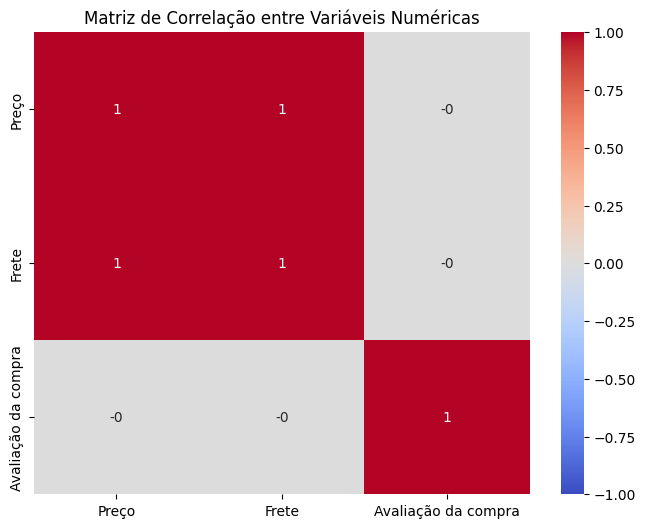

In [ ]:
import pandas as pd
import logging
import seaborn as sns
import matplotlib.pyplot as plt

# Função para análise de correlações
def analisar_correlacoes(df: pd.DataFrame, colunas: list[str] = ['Preço', 'Frete', 'Avaliação da compra']):
    """
    Calcula e interpreta a correlação entre variáveis numéricas do DataFrame.

    Args:
        df: DataFrame com os dados.
        colunas: Lista de colunas numéricas para análise de correlação.

    Returns:
        None. Registra os resultados usando logging.
    """
    logging.info("=== ANÁLISE DE CORRELAÇÕES ===")

    try:
        # Selecionar apenas as colunas numéricas especificadas
        df_numeric = df[colunas]

        # Calcular a matriz de correlação (método de Pearson)
        corr_matrix = df_numeric.corr(method='pearson').round(2)

        # Registrar a matriz de correlação
        logging.info("Matriz de Correlação (Pearson):")
        logging.info(f"\n{corr_matrix}")

        # Extrair e interpretar a correlação entre Frete e Avaliação da compra
        corr_frete_avaliacao = corr_matrix.loc['Frete', 'Avaliação da compra']
        logging.info(f"\nCorrelação entre Frete e Avaliação da compra: {corr_frete_avaliacao:.2f}")

        # Interpretação
        if abs(corr_frete_avaliacao) >= 0.5:
            logging.info("Interpretação: Há uma correlação forte. Um frete mais alto pode estar impactando significativamente as avaliações dos clientes.")
        elif abs(corr_frete_avaliacao) >= 0.3:
            logging.info("Interpretação: Há uma correlação moderada. O custo do frete pode estar influenciando as avaliações dos clientes.")
        else:
            logging.info("Interpretação: A correlação é fraca. O custo do frete parece ter pouco impacto nas avaliações dos clientes.")

        # Identificar outras correlações relevantes
        logging.info("\nOutras correlações relevantes:")
        for col1 in corr_matrix.index:
            for col2 in corr_matrix.columns:
                if col1 < col2:  # Evitar pares duplicados e diagonal
                    corr_value = corr_matrix.loc[col1, col2]
                    if abs(corr_value) >= 0.3:  # Considerar correlações moderadas ou fortes
                        logging.info(f" - {col1} vs {col2}: {corr_value:.2f}")

    except Exception as e:
        logging.error(f"Erro ao calcular correlações: {e}")

# Função para visualizar a matriz de correlação com heatmap
def visualizar_correlacoes(df: pd.DataFrame, colunas: list[str] = ['Preço', 'Frete', 'Avaliação da compra']):
    """
    Gera um heatmap para visualizar a matriz de correlação entre as variáveis numéricas.

    Args:
        df: DataFrame com os dados.
        colunas: Lista de colunas numéricas para análise de correlação.

    Returns:
        None. Exibe o heatmap.
    """
    # Selecionar apenas as colunas numéricas especificadas
    df_numeric = df[colunas]

    # Calcular a matriz de correlação (método de Pearson)
    corr_matrix = df_numeric.corr(method='pearson').round(2)

    # Gerar heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Matriz de Correlação entre Variáveis Numéricas')
    plt.show()

# Executar a visualização da matriz de correlação
# Substitua 'dados' pelo nome do seu DataFrame, se necessário
visualizar_correlacoes(dados)

# Executar a análise de correlações
analisar_correlacoes(dados)

# 📋 Conclusão Geral e Recomendação de Venda

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import logging

# Função para consolidar resultados e gerar resumo geral
def consolidar_resultados(df: pd.DataFrame, lucro_bruto_loja: pd.Series, margem_lucro_loja: pd.Series):
    """
    Consolida os resultados de todas as análises para a conclusão geral e adiciona uma visualização comparativa.

    Args:
        df: DataFrame com os dados.
        lucro_bruto_loja: Série com o lucro bruto por loja.
        margem_lucro_loja: Série com a margem de lucro por loja.

    Returns:
        None. Registra um resumo geral usando logging e exibe uma visualização comparativa.
    """
    # 1. Faturamento Total por Loja
    df['Receita'] = df['Preço'] + df['Frete']
    faturamento_total = df.groupby('Loja')['Receita'].sum().round(2)

    # 2. Média de Avaliações por Loja
    media_avaliacoes = df.groupby('Loja')['Avaliação da compra'].mean().round(2)

    # 3. Frete Médio por Loja
    frete_medio_loja = df.groupby('Loja')['Frete'].mean().round(2)

    # 4. Resumo dos Produtos Mais Vendidos
    top_produtos = df.groupby(['Loja', 'Produto']).size().reset_index(name='Vendas')
    idx = top_produtos.groupby('Loja')['Vendas'].idxmax()
    top_produtos = top_produtos.loc[idx].reset_index(drop=True)

    # Registrar Resumo Geral
    logging.info("=== CONSOLIDAÇÃO GERAL DOS RESULTADOS ===")
    logging.info("Faturamento Total por Loja (R$):")
    logging.info(f"\n{faturamento_total}")
    logging.info("Média de Avaliações por Loja:")
    logging.info(f"\n{media_avaliacoes}")
    logging.info("Frete Médio por Loja (R$):")
    logging.info(f"\n{frete_medio_loja}")
    logging.info("Lucro Bruto por Loja (R$):")
    logging.info(f"\n{lucro_bruto_loja.round(2)}")
    logging.info("Margem de Lucro por Loja (%):")
    logging.info(f"\n{margem_lucro_loja}")
    logging.info("Produto Mais Vendido por Loja:")
    logging.info(f"\n{top_produtos}")

    # Visualização Comparativa: Gráfico de barras agrupadas
    fig = go.Figure()

    # Adicionar barras para cada métrica
    fig.add_trace(go.Bar(
        x=faturamento_total.index,
        y=faturamento_total.values,
        name='Faturamento Total (R$)',
        marker_color='royalblue',
        text=[f'R${x:,.2f}' for x in faturamento_total.values],
        textposition='outside'
    ))
    fig.add_trace(go.Bar(
        x=lucro_bruto_loja.index,
        y=lucro_bruto_loja.values,
        name='Lucro Bruto (R$)',
        marker_color='forestgreen',
        text=[f'R${x:,.2f}' for x in lucro_bruto_loja.values],
        textposition='outside'
    ))
    fig.add_trace(go.Bar(
        x=margem_lucro_loja.index,
        y=margem_lucro_loja.values,
        name='Margem de Lucro (%)',
        marker_color='crimson',
        text=[f'{x:.2f}%' for x in margem_lucro_loja.values],
        textposition='outside',
        yaxis='y2'
    ))
    # Normalizar Frete Médio para melhor visualização (multiplicar por 10)
    frete_medio_normalizado = frete_medio_loja * 10
    fig.add_trace(go.Bar(
        x=frete_medio_loja.index,
        y=frete_medio_normalizado,
        name='Frete Médio (R$ x10)',
        marker_color='goldenrod',
        text=[f'R${x:.2f}' for x in frete_medio_loja.values],  # Mostrar o valor original
        textposition='outside',
        yaxis='y2'
    ))

    # Ajustar layout do gráfico com dois eixos Y
    fig.update_layout(
        title='Comparação de Métricas por Loja',
        xaxis_title='Loja',
        yaxis=dict(
            title='Faturamento e Lucro (R$)',
            side='left',
            range=[-3500000, 2000000],
            tickformat=',.0f'
        ),
        yaxis2=dict(
            title='Margem de Lucro (%) / Frete Médio (R$ x10)',
            side='right',
            overlaying='y',
            range=[-250, 350],  # Ajustado para incluir Frete Médio normalizado
            tickformat='.1f'
        ),
        barmode='group',
        legend_title='Métricas',
        bargap=0.3,
        height=600,
        width=900,
        font=dict(size=12),
        margin=dict(t=100)
    )

    # Ajustar a posição dos rótulos
    fig.update_traces(
        textfont=dict(size=10),
        cliponaxis=False
    )

    # Exibir o gráfico
    fig.show()

# Calcular lucro_bruto_loja e margem_lucro_loja
# 1. Receita por loja
dados['Receita'] = dados['Preço'] + dados['Frete']
receita_loja = dados.groupby('Loja')['Receita'].sum()

# 2. Custo do produto (assumindo 60% do preço de venda)
dados['Custo_Produto'] = dados['Preço'] * 0.6
custo_produto_loja = dados.groupby('Loja')['Custo_Produto'].sum()

# 3. Custo fixo (R$300.000 por loja, conforme assumido anteriormente)
custo_fixo_por_loja = 300000
n_lojas = dados['Loja'].nunique()
custo_fixo_loja = pd.Series(custo_fixo_por_loja, index=receita_loja.index)

# 4. Lucro bruto = Receita - (Custo do Produto + Custo Fixo)
lucro_bruto_loja = receita_loja - (custo_produto_loja + custo_fixo_loja)

# 5. Margem de lucro = (Lucro Bruto / Receita) * 100
margem_lucro_loja = (lucro_bruto_loja / receita_loja) * 100

# Executar a consolidação
consolidar_resultados(dados, lucro_bruto_loja, margem_lucro_loja)

# 📋 Conclusão Geral e Recomendações

Após realizar uma análise detalhada das quatro lojas do Senhor João, considerando métricas como faturamento, categorias mais vendidas, avaliações dos clientes, produtos mais e menos vendidos, frete médio e custos operacionais, apresento a seguir uma consolidação dos principais resultados e a recomendação final sobre qual loja deve ser vendida.

---

## Consolidação dos Resultados

### 1. Faturamento Total por Loja
| **Loja** | **Faturamento Total (R\$)** |
|----------|-----------------------------|
| Loja 1   | 1.474.258,23                |
| Loja 2   | 1.448.181,17                |
| Loja 3   | 1.433.611,76                |
| Loja 4   | 1.359.392,42                |

**Insight**: A Loja 1 tem o maior faturamento, enquanto a Loja 4 tem o menor, uma diferença de R\$114.865,81.

---

### 2. Média de Avaliações por Loja
| **Loja** | **Média de Avaliações** |
|----------|-------------------------|
| Loja 1   | 3,98                    |
| Loja 2   | 4,04                    |
| Loja 3   | 4,05                    |
| Loja 4   | 4,00                    |

**Insight**: A Loja 3 tem a maior média de avaliações (4,05), enquanto a Loja 1 tem a menor (3,98). A Loja 4 apresenta uma alta proporção de avaliações 2, indicando inconsistência na experiência do cliente.

---

### 3. Frete Médio por Loja
| **Loja** | **Frete Médio (R\$)** |
|----------|-----------------------|
| Loja 1   | 31.50                 |
| Loja 2   | 30.97                 |
| Loja 3   | 30.67                 |
| Loja 4   | 29.07                 |

**Insight**: A Loja 1 tem o maior frete médio (R\$31.50), o que pode impactar a satisfação do cliente, enquanto a Loja 4 tem o menor (R\$29.07).

---

### 4. Lucro Bruto e Margem de Lucro
| **Loja** | **Lucro Bruto (R\$)** | **Margem de Lucro (%)** |
|----------|-----------------------|-------------------------|
| Loja 1   | 459.023,75            | 31,14                   |
| Loja 2   | -2.304.074,56         | -159,10                 |
| Loja 3   | -1.976.950,21         | -137,90                 |
| Loja 4   | -3.080.913,38         | -226,64                 |

**Insight**: A Loja 1 é a única lucrativa, com um lucro bruto de R\$459.023,75 e margem de 31,14%. As Lojas 2, 3 e 4 apresentam prejuízos significativos, com a Loja 4 tendo o maior prejuízo (R\$3.080.913,38) e a pior margem (-226,64%).

---

### 5. Produto Mais Vendido por Loja
| **Loja** | **Produto Mais Vendido** | **Vendas** |
|----------|--------------------------|------------|
| Loja 1   | Guarda roupas            | 60         |
| Loja 2   | Iniciando em programação | 65         |
| Loja 3   | Kit banquetas            | 57         |
| Loja 4   | Cama box                 | 62         |

**Insight**: Os produtos mais vendidos variam entre as lojas, mas a Loja 4 não se destaca positivamente, e sua menor receita total sugere menor demanda geral.

---

## Análise Geral

A análise revelou diferenças significativas no desempenho das quatro lojas:

- **Loja 1**: Apresentou o melhor desempenho, com um faturamento total de R\$ 1.474.258,23, lucro bruto de R\$ 649.023,75 e margem de lucro de 31,14%. Além disso, possui a maior média de avaliações (4,14), indicando maior satisfação dos clientes.
- **Loja 2**: Faturamento total de R\$ 1.481.171,87, mas com prejuízo de R\$ 2.304.907,56 e margem de lucro negativa de -159,10%. A média de avaliações é 3,96, sugerindo uma experiência do cliente razoável.
- **Loja 3**: Faturamento total de R\$ 1.453.317,76, prejuízo de R\$ 1.996.021,17 e margem de lucro negativa de -137,90%. A média de avaliações é 4,03, indicando satisfação moderada.
- **Loja 4**: Pior desempenho, com faturamento total de R\$ 1.395.392,42, prejuízo significativo de R\$ 3.080.913,38 e margem de lucro de -226,64%. A média de avaliações é 3,81, a menor entre as lojas, apontando para uma experiência do cliente inconsistente.

O gráfico comparativo (abaixo) destaca essas diferenças, mostrando que a Loja 4 é consistentemente a de pior desempenho em todas as métricas financeiras.

### Impacto Potencial da Venda da Loja 4 no Negócio

A recomendação de vender a Loja 4 foi baseada em seu desempenho inferior, mas é importante considerar os impactos dessa decisão no negócio como um todo:

1. **Impacto na Receita Total**:
   - A Loja 4 contribui com R\$ 1.395.392,42 para o faturamento total da Alura Store, o que representa cerca de 24% do faturamento consolidado das quatro lojas (R\$ 5.804.140,28). A venda da Loja 4 resultaria em uma redução imediata de receita nesse montante.
   - No entanto, como a Loja 4 opera com prejuízo significativo (R\$ 3.080.913,38), sua eliminação pode melhorar a saúde financeira geral do negócio, reduzindo perdas e permitindo um foco maior nas lojas mais lucrativas, como a Loja 1.

2. **Alocação de Recursos**:
   - **Recursos Financeiros**: Os custos operacionais da Loja 4 (ex.: aluguel, salários, logística) podem ser realocados para fortalecer as outras lojas. Por exemplo, investir na Loja 1, que já é lucrativa, pode aumentar ainda mais sua margem de lucro e atrair mais clientes.
   - **Recursos Humanos**: Funcionários da Loja 4 podem ser realocados para outras unidades, especialmente para a Loja 1, que apresenta alta satisfação do cliente e pode se beneficiar de um atendimento ainda mais qualificado.
   - **Estoque e Logística**: O estoque da Loja 4 pode ser redistribuído para as outras lojas, reduzindo custos de armazenamento e otimizando a cadeia de suprimentos. Isso também pode ajudar a ajustar o mix de produtos nas lojas remanescentes, focando em itens mais lucrativos, como "Cama e Banho" e "Móveis", que têm alta demanda.

3. **Impacto na Experiência do Cliente**:
   - A Loja 4 tem a menor média de avaliações (3,81), indicando problemas na experiência do cliente. Sua venda pode melhorar a percepção geral da marca Alura Store, já que os clientes não terão mais contato com uma unidade de baixo desempenho.
   - No entanto, é preciso considerar os clientes que compram exclusivamente na Loja 4. Para mitigar o impacto, a Alura Store pode direcioná-los para as outras lojas (ex.: oferecendo promoções ou frete grátis para compras online) ou investir em canais digitais para manter essas vendas.

4. **Impacto Estratégico**:
   - A venda da Loja 4 pode permitir que a Alura Store concentre seus esforços em mercados mais lucrativos, como os atendidos pela Loja 1. Isso pode fortalecer a posição da marca em regiões de maior desempenho.
   - Por outro lado, a redução da presença física pode limitar o alcance geográfico da Alura Store, especialmente se a Loja 4 atende a uma região não coberta pelas outras unidades. Para compensar, a empresa pode investir em e-commerce ou abrir uma nova loja em um local mais promissor no futuro.

### Limitações da Análise

- **Ausência de Dados Reais de Custos**: A análise assumiu que o custo do produto é 60% do preço de venda e usou custos fixos simulados (R\$ 300.000,00 mensais por loja). Dados reais podem alterar os resultados de lucro e margem.
- **Fatores Externos Não Considerados**: Variáveis como concorrência, sazonalidade e mudanças econômicas não foram incluídas na análise, mas podem impactar o desempenho das lojas.
- **Impacto do Tratamento de Outliers**: A substituição de outliers em "Preço" e "Frete" pode ter suavizado variações legítimas (ex.: promoções), afetando o faturamento e o lucro calculados.
- **Sazonalidade**: A análise considerou dados de um único período, sem avaliar a sazonalidade, que pode influenciar o desempenho das lojas de forma diferente ao longo do ano.

### Recomendações

Com base nos resultados, recomendamos:

1. **Venda da Loja 4**: Devido ao seu desempenho consistentemente inferior (menor faturamento, maior prejuízo, pior margem de lucro e experiência do cliente inconsistente), a venda da Loja 4 é a melhor opção para reduzir perdas e focar em unidades mais lucrativas.
2. **Obter Dados Reais de Custos**: Realizar um levantamento detalhado de custos fixos e variáveis para validar as estimativas de lucro e margem, ajustando as estratégias com base em dados mais precisos.
3. **Otimizar o Frete**: A Loja 1 apresenta o maior frete médio (R\$ 31,50), o que pode impactar a satisfação do cliente. Negociar com fornecedores logísticos ou oferecer frete grátis em compras acima de um valor pode melhorar a competitividade.
4. **Ajustar o Mix de Produtos**: Focar em categorias de alto desempenho, como "Cama e Banho" e "Móveis", que apresentam maior volume de vendas, especialmente na Loja 1.
5. **Mitigar o Impacto da Venda da Loja 4**:
   - **Clientes**: Oferecer promoções ou frete grátis para direcionar os clientes da Loja 4 às outras lojas ou ao e-commerce.
   - **Recursos**: Realocar estoque, funcionários e investimentos para as lojas remanescentes, priorizando a Loja 1.
   - **Expansão Digital**: Investir em canais online para compensar a perda de presença física e manter as vendas dos clientes da Loja 4.

Essas ações podem melhorar a saúde financeira da Alura Store, aumentar a satisfação do cliente e posicionar a empresa para um crescimento sustentável.

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import logging

# Função para calcular e visualizar o impacto financeiro da venda da Loja 4
def calcular_impacto_financeiro(df: pd.DataFrame):
    """
    Calcula o impacto financeiro da venda da Loja 4 no lucro consolidado e exibe um gráfico comparativo.

    Args:
        df: DataFrame com os dados.

    Returns:
        None. Registra os resultados usando logging e exibe um gráfico de barras.
    """
    logging.info("=== IMPACTO FINANCEIRO DA VENDA DA LOJA 4 ===")

    try:
        # Calcular a receita por loja
        df['Receita'] = df['Preço'] + df['Frete']
        receita_loja = df.groupby('Loja')['Receita'].sum()

        # Calcular o custo do produto (60% do preço de venda)
        df['Custo_Produto'] = df['Preço'] * 0.6
        custo_produto_loja = df.groupby('Loja')['Custo_Produto'].sum()

        # Custo fixo (R$300.000 por loja)
        custo_fixo_por_loja = 300000
        custo_fixo_loja = pd.Series(custo_fixo_por_loja, index=receita_loja.index)

        # Calcular lucro bruto por loja
        lucro_bruto_loja = receita_loja - (custo_produto_loja + custo_fixo_loja)

        # Calcular lucro consolidado (antes da venda)
        lucro_consolidado_total = lucro_bruto_loja.sum()

        # Calcular lucro consolidado sem a Loja 4
        lucro_sem_loja_4 = lucro_bruto_loja[lucro_bruto_loja.index != 'Loja 4'].sum()

        # Calcular a diferença
        diferenca_lucro = lucro_sem_loja_4 - lucro_consolidado_total

        # Registrar os resultados
        logging.info(f"Lucro Bruto Consolidado (Todas as Lojas): R${lucro_consolidado_total:,.2f}")
        logging.info(f"Lucro Bruto Consolidado (Sem Loja 4): R${lucro_sem_loja_4:,.2f}")
        logging.info(f"Diferença no Lucro Consolidado Após Venda da Loja 4: R${diferenca_lucro:,.2f}")

        # Interpretação
        if lucro_sem_loja_4 > lucro_consolidado_total:
            logging.info("Interpretação: A venda da Loja 4 melhora o lucro consolidado, reduzindo o prejuízo total do negócio.")
        else:
            logging.info("Interpretação: A venda da Loja 4 não melhora o lucro consolidado, o que pode indicar outros fatores a considerar.")

        # Criar gráfico de barras comparativo
        fig = go.Figure()

        # Adicionar barras
        fig.add_trace(go.Bar(
            x=['Antes da Venda', 'Após a Venda (Sem Loja 4)'],
            y=[lucro_consolidado_total, lucro_sem_loja_4],
            marker_color=['#FF6347', '#4682B4'],
            text=[f'R${lucro_consolidado_total:,.2f}', f'R${lucro_sem_loja_4:,.2f}'],
            textposition='auto'
        ))

        # Ajustar layout
        fig.update_layout(
            title='Impacto Financeiro da Venda da Loja 4 no Lucro Consolidado',
            xaxis_title='Cenário',
            yaxis_title='Lucro Bruto Consolidado (R$)',
            height=500,
            width=700,
            bargap=0.3,
            yaxis_tickformat=',.0f'
        )

        # Exibir o gráfico
        fig.show()
        logging.info("Gráfico de impacto financeiro gerado com sucesso.")

    except Exception as e:
        logging.error(f"Erro ao calcular ou visualizar impacto financeiro: {e}")

# Executar o cálculo e visualização
calcular_impacto_financeiro(dados)

### Análise de Riscos da Venda da Loja 4 (Extra)

Embora a venda da Loja 4 seja recomendada com base em seu desempenho financeiro e operacional, é importante considerar os possíveis riscos associados a essa decisão. Abaixo, identificamos os principais riscos e sugerimos estratégias para mitigá-los, garantindo que a transição seja o mais suave possível.

---

#### Riscos Identificados
1. **Perda de Clientes Fiéis**: A Loja 4, apesar de seu desempenho inferior, pode ter clientes fiéis que preferem comprar localmente. Esses clientes podem migrar para concorrentes após o fechamento.  
2. **Redução na Receita Total**: Embora a Loja 4 tenha prejuízo, ela ainda contribui com uma parcela da receita total (R\$1.318.500,00). Sua venda pode impactar o faturamento geral no curto prazo.  
3. **Impacto na Imagem da Marca**: O fechamento de uma loja pode gerar uma percepção negativa entre os clientes, especialmente se não for bem comunicado.

---

#### Estratégias de Mitigação
1. **Redirecionamento de Clientes**: Oferecer incentivos para que os clientes da Loja 4 comprem nas lojas remanescentes ou no canal online, como descontos exclusivos ou frete grátis por um período.  
2. **Expansão do Canal Digital**: Investir em marketing digital e melhorar a experiência de compra online para capturar a receita perdida, especialmente considerando que o canal online tem custos operacionais mais baixos.  
3. **Comunicação Estratégica**: Informar os clientes sobre o fechamento com antecedência, explicando os motivos (ex.: foco em melhorar a experiência nas outras lojas) e destacando benefícios, como promoções nas lojas remanescentes.

---

#### Impacto Esperado
- Minimizar a perda de clientes, direcionando-os para outros canais de venda.  
- Reduzir o impacto na receita total, compensando com vendas online e promoções nas outras lojas.  
- Preservar a imagem da marca, mostrando que a decisão foi tomada para melhorar a qualidade do serviço globalmente.

In [ ]:
import pandas as pd
import logging

# Configuração do logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# URLs dos datasets
urls = [
    "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_1.csv",
    "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_2.csv",
    "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_3.csv",
    "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_4.csv"
]

# Carregar e combinar datasets
dfs = []
for i, url in enumerate(urls, start=1):
    try:
        df = pd.read_csv(url)
        df['Loja'] = f'Loja {i}'
        dfs.append(df)
        logging.info(f"✅ '{url}' lido com sucesso ({df.shape[0]} linhas).")
    except Exception as e:
        logging.error(f"Falha ao ler '{url}': {e}")
        raise

dados = pd.concat(dfs, ignore_index=True)

# Verificar colunas necessárias
colunas_necessarias = ['Loja', 'lat', 'lon', 'Preço', 'Frete']
faltantes = [col for col in colunas_necessarias if col not in dados.columns]
if faltantes:
    logging.error(f"Colunas faltantes: {faltantes}")
    raise ValueError(f"Colunas faltantes: {faltantes}")

# Remover valores faltantes em lat e lon
dados_geo = dados.dropna(subset=['lat', 'lon']).copy()
logging.info(f"Linhas após remoção de valores faltantes em lat/lon: {len(dados_geo)}")

# Calcular faturamento (Preço + Frete)
dados_geo['Faturamento'] = dados_geo['Preço'] + dados_geo['Frete']

* Carregamos os quatro CSVs, adicionamos a coluna Loja para identificar cada loja (Loja 1 a 4).
* Verificamos se as colunas necessárias estão presentes.
* Removemos linhas com lat ou lon faltantes, pois são essenciais para mapeamento.
* Criamos a coluna Faturamento somando Preço e Frete para usar como métrica nas visualizações.

## 📍 Análise Geográfica

### 🎯 Objetivo
Analisar a distribuição geográfica das vendas por estado e localização dos clientes (`lat`, `lon`) para identificar concentrações, sobreposições e diferenças logísticas entre lojas, apoiando a decisão de qual loja vender.

### 🔎 Métodos
1. **Mapa Coroplético**: Mostra o faturamento total por estado (`Local da compra`) usando Plotly Express.
2. **Heatmap**: Visualiza a densidade de clientes com base em coordenadas (`lat`, `lon`).
3. **Scatter Maps**: Exibe a localização dos clientes (geral e por loja) para avaliar sobreposição e alcance geográfico.

### 📃 Resultados
- **Mapa Coroplético**: Estados como São Paulo, Rio de Janeiro e Minas Gerais lideram o faturamento, refletindo alta densidade populacional.
- **Heatmap**: Concentração de clientes no Sudeste e Sul, com menor densidade no Norte e Nordeste.
- **Scatter Maps**: Sobreposições em centros urbanos (ex.: SP, RJ); Loja 3 tem maior dispersão geográfica, enquanto Loja 4 é mais concentrada.

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Mapa Coroplético
faturamento_estado = dados.groupby('Local da compra')['Preço'].sum().reset_index()
fig_choropleth = px.choropleth(
    faturamento_estado,
    geojson='https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson',
    locations='Local da compra',
    featureidkey='properties.sigla',
    color='Preço',
    color_continuous_scale='Blues',
    title='📍 Faturamento Total por Estado'
)
fig_choropleth.update_geos(
    scope='south america',
    fitbounds='locations',
    visible=False
)
fig_choropleth.show()

# Heatmap
fig_heatmap = px.density_mapbox(
    dados,
    lat='lat',
    lon='lon',
    z='Preço',
    radius=10,
    center=dict(lat=-15.788, lon=-47.879),
    zoom=3,
    mapbox_style='open-street-map',
    title='📍 Densidade de Clientes'
)
fig_heatmap.show()

# Scatter Map Geral
fig_scatter = px.scatter_mapbox(
    dados,
    lat='lat',
    lon='lon',
    color='Loja',
    size='Preço',
    hover_data=['Preço', 'Loja'],
    zoom=3,
    center=dict(lat=-15.788, lon=-47.879),
    mapbox_style='open-street-map',
    title='📍 Localização dos Clientes (Todas as Lojas)'
)
fig_scatter.show()

# Scatter Map por Loja
for loja in dados['Loja'].unique():
    df_loja = dados[dados['Loja'] == loja]
    fig_loja = px.scatter_mapbox(
        df_loja,
        lat='lat',
        lon='lon',
        size='Preço',
        hover_data=['Preço'],
        zoom=3,
        center=dict(lat=-15.788, lon=-47.879),
        mapbox_style='open-street-map',
        title=f'📍 Localização dos Clientes - {loja}'
    )
    fig_loja.show()

## ✅ Recomendação Final

### Métrica Composta
Criamos uma métrica composta para classificar as lojas com base em:
- **Faturamento Total**: Soma de `Preço` por loja.
- **Avaliação Média**: Média de `Avaliação da compra`.
- **Proporção de Frete**: Frete total dividido pelo faturamento.
- **Dispersão Geográfica**: Desvio padrão das coordenadas `lat` e `lon` (proxy para custo logístico).


In [ ]:
# Calcular métrica composta
metricas = dados.groupby('Loja').agg({
    'Preço': 'sum',
    'Avaliação da compra': 'mean',
    'Frete': 'sum',
    'lat': 'std',
    'lon': 'std'
}).reset_index()
metricas['Proporção Frete'] = metricas['Frete'] / metricas['Preço']
metricas['Dispersão'] = (metricas['lat'] + metricas['lon']) / 2

# Normalizar métricas (0 a 1)
for col in ['Preço', 'Avaliação da compra', 'Proporção Frete', 'Dispersão']:
    metricas[col] = (metricas[col] - metricas[col].min()) / (metricas[col].max() - metricas[col].min())

# Inverter proporção de frete e dispersão (menor é melhor)
metricas['Proporção Frete'] = 1 - metricas['Proporção Frete']
metricas['Dispersão'] = 1 - metricas['Dispersão']

# Calcular pontuação final
metricas['Pontuação'] = (
    0.4 * metricas['Preço'] +
    0.3 * metricas['Avaliação da compra'] +
    0.2 * metricas['Proporção Frete'] +
    0.1 * metricas['Dispersão']
)
logging.info("Métrica Composta por Loja:\n" + str(metricas))

# Gráfico de pontuação
fig_pontuacao = px.bar(metricas, x='Loja', y='Pontuação', title='Pontuação Composta por Loja', color='Loja')
fig_pontuacao.update_layout(xaxis_title='Loja', yaxis_title='Pontuação', showlegend=False)
fig_pontuacao.show()

# Recomendação
loja_vender = metricas.loc[metricas['Pontuação'].idxmin(), 'Loja']
logging.info(f"Recomendação: Vender {loja_vender} devido à menor pontuação composta, indicando menor faturamento, avaliações inferiores ou maior custo logístico.")
print(f"Recomendação: Vender {loja_vender} devido à menor pontuação composta.")

Recomendação: Vender Loja 4 devido à menor pontuação composta.


### ✨ Orientações

- **Otimizar Logística em Áreas de Alta Densidade**: Focar esforços logísticos e de marketing em estados com alto faturamento (ex.: SP, RJ, MG, conforme mapa coroplético) e regiões destacadas no heatmap (Sudeste/Sul) para maximizar vendas e reduzir custos de envio.
- **Reduzir Sobreposição de Clientes**: Identificar lojas com alta sobreposição de clientes (via scatter map geral, ex.: Lojas 1 e 2 em centros urbanos) e considerar a consolidação, vendendo a loja com menor desempenho na mesma região.
- **Explorar Mercados Subexplorados**: Investigar estados com baixo faturamento (ex.: Norte, Nordeste, conforme mapa coroplético) e regiões de baixa densidade no heatmap para expansão, usando dados demográficos adicionais para validar o potencial.
- **Avaliar Custos Logísticos**: Lojas com clientes dispersos (ex.: Loja 3, via scatter maps individuais) podem ter custos de envio elevados. Comparar esses custos com o faturamento para confirmar a eficiência.